<div align="center">
<h1 style="color:#1565c0; font-size:2.8em; font-weight:bold; margin-bottom:0.2em; margin-top:0.5em;">Практична робота №2</h1>
<h3 style="color:#1976d2; margin-top:0; font-weight:normal;">Побудова та оцiнювання якостi
моделей класифiкацiї та регресiї засобами бiблiотеки <b>Scikit-Learn Python</b></h3>
<br>
<br>
<b>Варіант 12</b><br>
<b>Автори:</b><br>
Плахтій Злата, КА-32<br>
Пастушенко Максим, КА-33<br>
Романов Фелікс, КА-33
</div>

<b>Мета:</b> Метою роботи є побудова та оцiнювання якостi моделей:
- дерев рiшень,
- опорних векторiв,
- логiстичної регресiї,
- наївної баєсiвської моделi
для класифiкацiї та регресiї засобами бiблiотеки Scikit-Learn Python.

<b>Хід роботи:</b>
1. Підготувати дані.
2. Представити початкових даних графiчно.
3. Розбити данi на навчальний та валiдацiйний набори.
4. Побудувати на навчальному наборi даних моделi класифiкацiї або регресiї заданi згiдно з варiантом.
4. Представити моделi графiчно (наприклад вивести частину дерева рiшень, побудувати лiнiю регресiї тощо).
5. Виконати прогнози на основi побудованих моделей.
6. Для кожної з моделей оцiнити, чи має мiсце перенавчання.
7. В задачах регресiї розрахувати для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

    • коефiцiєнт детермiнацiї R2,
    
    • помилки RMSE, MAE та MAPE.

8. Спробувати виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей.
9. Зробити висновки про якiсть роботи моделей на дослiджених даних. На
основi критерiїв якостi спробувати обрати найкращу модель.
10. Навчити моделi на пiдмножинах навчальних даних. Оцiнити, наскiльки
розмiр навчальної множини впливає на якiсть моделi.
11. Кожний варiант мiстить два набори даних. Дослiдити обидва набори за
наведеними вище етапами.

<b>Завдання:</b><br>
Побудувати моделi регресiї на основi нейронної мережі, визначити, чи достатньо буде одношарової моделі для опису даних. Реалізувати динамічне додавання нейронів до скритого шару. Перевірити, скільки нейронів в одношаровій моделі буде достатньо для задовільного розв'язання задачі.<br><br>

Початковi данi:<br>
(б) [avocado_prices.csv](https://www.kaggle.com/datasets/neuromusic/avocado-prices)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

In [3]:
# ------------------------------
# 1.1. Завантаження та огляд даних
# ------------------------------

# Load
df = pd.read_csv('data/avocado.csv')
df.columns = df.columns.str.strip()

# Header
print(f"Rows: {df.shape[0]:,}  |  Cols: {df.shape[1]:,}  |  Memory: {df.memory_usage(deep=True).sum()/1024**2:.3f} MB")
print("Columns:", ", ".join(df.columns))

# Types + non-null + unique (compact)
info = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "unique": df.nunique(dropna=False)
})
print("\nTypes / non-null / unique:")
print(info.to_string())

# Quick peek
print("\nHead:")
print(df.head().to_string(index=False))

# Numeric descriptive (compact)
num = df.select_dtypes(include=[np.number])
if not num.empty:
    print("\nNumeric summary:")
    print(num.describe().T.loc[:, ["count","mean","std","min","50%","max"]].to_string(float_format="{:,.3f}".format))

# Missing values
miss = df.isna().sum()
miss = miss[miss>0].sort_values(ascending=False)
print("\nMissing values:")
if miss.empty:
    print("  None")
else:
    pct = (miss/len(df)*100).round(2)
    for c in miss.index:
        print(f"  {c}: {miss[c]} ({pct[c]}%)")

# Duplicates
dups = df.duplicated().sum()
print(f"\nDuplicate rows: {dups}")
if dups:
    print("  First duplicates:")
    print(df[df.duplicated(keep='first')].head(3).to_string(index=False))

# Date parsing
if 'Date' in df.columns:
    parsed = pd.to_datetime(df['Date'], errors='coerce')
    bad = parsed.isna().sum()
    print(f"\nDate column: original dtype={df['Date'].dtype}, parse_failures={bad}")
    if bad==0:
        print(f"  Date range: {parsed.min().date()} — {parsed.max().date()}")
    else:
        print("  Example unparsable Date values:")
        print(df.loc[parsed.isna(), 'Date'].drop_duplicates().head(5).to_string(index=False))

# Quick numeric sanity checks
neg = [(c,int((df[c]<0).sum())) for c in num.columns if (df[c]<0).any()]
if neg:
    print("\nNegative values found:")
    for c,n in neg:
        print(f"  {c}: {n}")
else:
    print("\nNo negative values in numeric columns (quick check).")

Rows: 18,249  |  Cols: 14  |  Memory: 4.609 MB
Columns: Unnamed: 0, Date, AveragePrice, Total Volume, 4046, 4225, 4770, Total Bags, Small Bags, Large Bags, XLarge Bags, type, year, region

Types / non-null / unique:
                dtype  non_null  unique
Unnamed: 0      int64     18249      53
Date           object     18249     169
AveragePrice  float64     18249     259
Total Volume  float64     18249   18237
4046          float64     18249   17702
4225          float64     18249   18103
4770          float64     18249   12071
Total Bags    float64     18249   18097
Small Bags    float64     18249   17321
Large Bags    float64     18249   15082
XLarge Bags   float64     18249    5588
type           object     18249       2
year            int64     18249       4
region         object     18249      54

Head:
 Unnamed: 0       Date  AveragePrice  Total Volume    4046      4225   4770  Total Bags  Small Bags  Large Bags  XLarge Bags         type  year region
          0 2015-12-27    

In [4]:
# ------------------------------
# 1.2. Data Preparation
# ------------------------------

# Drop unnecessary columns
drop_candidates = ['Unnamed: 0', 'Unnamed:0', 'year']
drop_cols = [c for c in drop_candidates if c in df.columns]
if drop_cols:
    df.drop(columns=drop_cols, inplace=True)
    print('\nDropped utility columns:', drop_cols)
    
# Convert 'Date' column to datetime type
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    print("\nConverted 'Date' to datetime. Null dates found:", df['Date'].isnull().sum())

    # If there are nulls in 'Date', they can be dropped
    if df['Date'].isnull().any():
        n_dt = df['Date'].isnull().sum()
        df = df[~df['Date'].isnull()]
        print(f"Dropped {n_dt} rows with invalid Date.")

    # --- Feature Engineering from Date ---
    # year, month, week
    df['year'] = df['Date'].dt.year
    # month as integer (1-12)
    df['month'] = df['Date'].dt.month
    # ISO week (pandas >= 1.1 returns an isocalendar DataFrame)
    try:
        df['week'] = df['Date'].dt.isocalendar().week.astype(int)
    except Exception:
        # compatibility with older pandas versions
        df['week'] = df['Date'].dt.week.astype(int)

    # cyclical encoding for month (recommended for seasonality)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    # ------------------------------------------

# Rename PLU columns
rename_map = {}
for c in ['4046', '4225', '4770']:
    if c in df.columns:
        rename_map[c] = f'PLU_{c}'
if rename_map:
    df = df.rename(columns=rename_map)
    print("\nRenamed columns:", rename_map)

# Remove complete duplicate rows
dup_count = df.duplicated().sum()
if dup_count:
    df = df.drop_duplicates()
print(f"\nRemoved {dup_count} duplicate rows (if any).")

# Encode categorical features (type -> binary; region -> frequency encoding later)
# type conventional -> 0, organic -> 1
if 'type' in df.columns:
    
    # normalize strings to handle different cases
    df['type'] = df['type'].astype(str).str.strip().str.lower()
    type_map = {'conventional': 0, 'organic': 1}
    
    # Check for unexpected values that won't be mapped
    other_vals = set(df['type'].unique()) - set(type_map.keys())
    if other_vals:
        print("Warning: unexpected values in 'type':", other_vals)
    df['type'] = df['type'].map(type_map)
    
    # If mapping resulted in nulls (due to unexpected values), drop them
    if df['type'].isnull().any():
        n = df['type'].isnull().sum()
        df = df[~df['type'].isnull()]
        print(f"Dropped {n} rows with unmapped 'type' values.")

# Final check of data types
print("\nDtypes after preprocessing:\n", df.dtypes)
print("Shape:", df.shape)

# Save the prepared data
SAVE_PATH = 'data/avocado_prepared.csv'
df.to_csv(SAVE_PATH, index=False)
print(f"\nPreprocessing complete. Data saved to: {SAVE_PATH}")
print('\nShape after preparation:', df.shape)
print(df.head())


Dropped utility columns: ['Unnamed: 0', 'year']

Converted 'Date' to datetime. Null dates found: 0

Renamed columns: {'4046': 'PLU_4046', '4225': 'PLU_4225', '4770': 'PLU_4770'}

Removed 0 duplicate rows (if any).

Dtypes after preprocessing:
 Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
PLU_4046               float64
PLU_4225               float64
PLU_4770               float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                     int64
region                  object
year                     int32
month                    int32
week                     int64
month_sin              float64
month_cos              float64
dtype: object
Shape: (18249, 17)

Preprocessing complete. Data saved to: data/avocado_prepared.csv

Shape after preparation: (18249, 17)
        Date  AveragePrice  Total Volume  PLU_4046   PLU_4225  PLU_4770  \
0 2015-12-27    

In [5]:

# ------------------------------
# 2.1. Візуалізація даних
# ------------------------------

# Завантажити підготовлений файл 
df = pd.read_csv('data/avocado_prepared.csv', parse_dates=['Date'])

# Ensure Date and month
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
if 'month' not in df.columns and 'Date' in df.columns:
    df['month'] = df['Date'].dt.month

# Prepare type labels
types_sorted = sorted(df['type'].dropna().unique()) if 'type' in df.columns else []
labels = {0: 'conventional', 1: 'organic'}



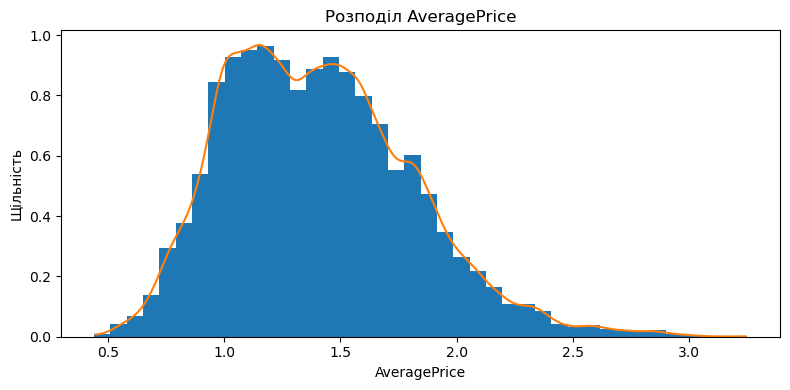

In [6]:
# Розподіл AveragePrice

plt.figure(figsize=(8,4))
vals_series = df['AveragePrice'].dropna()
plt.hist(vals_series, bins=40, density=True)
vals, bins = np.histogram(vals_series, bins=200, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, gaussian_filter1d(vals, sigma=3))
plt.title('Розподіл AveragePrice')
plt.xlabel('AveragePrice')
plt.ylabel('Щільність')
plt.tight_layout()
plt.show()

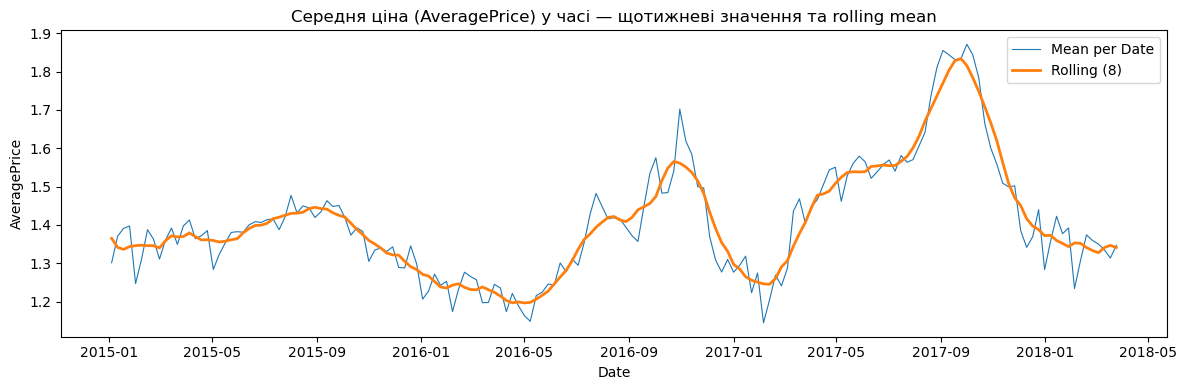

In [7]:
# AveragePrice протягом часу

plt.figure(figsize=(12,4))
price_by_date = df.groupby('Date')['AveragePrice'].mean()
plt.plot(price_by_date.index, price_by_date.values, linewidth=0.8, label='Mean per Date')
rolling = price_by_date.rolling(window=8, center=True, min_periods=1).mean()
plt.plot(rolling.index, rolling.values, linewidth=2, label='Rolling (8)')
plt.title('Середня ціна (AveragePrice) у часі — щотижневі значення та rolling mean')
plt.xlabel('Date')
plt.ylabel('AveragePrice')
plt.legend()
plt.tight_layout()
plt.show()

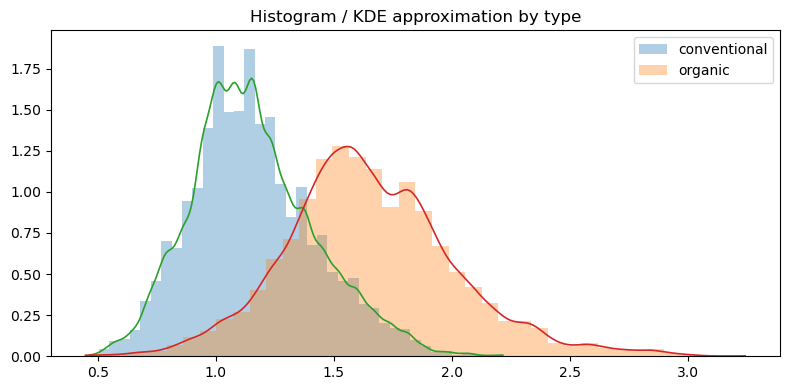

In [8]:
plt.figure(figsize=(8,4))
for t in types_sorted:
    s = df[df['type'] == t]['AveragePrice'].dropna()
    if s.empty: 
        continue
    plt.hist(s, bins=40, density=True, alpha=0.35, label=labels.get(t, str(t)))

for t in types_sorted:
    s = df[df['type'] == t]['AveragePrice'].dropna()
    if s.empty:
        continue
    vals, bins = np.histogram(s, bins=200, density=True)
    centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(centers, gaussian_filter1d(vals, sigma=3), linewidth=1.2)

plt.legend()
plt.title('Histogram / KDE approximation by type')
plt.tight_layout()
plt.show()

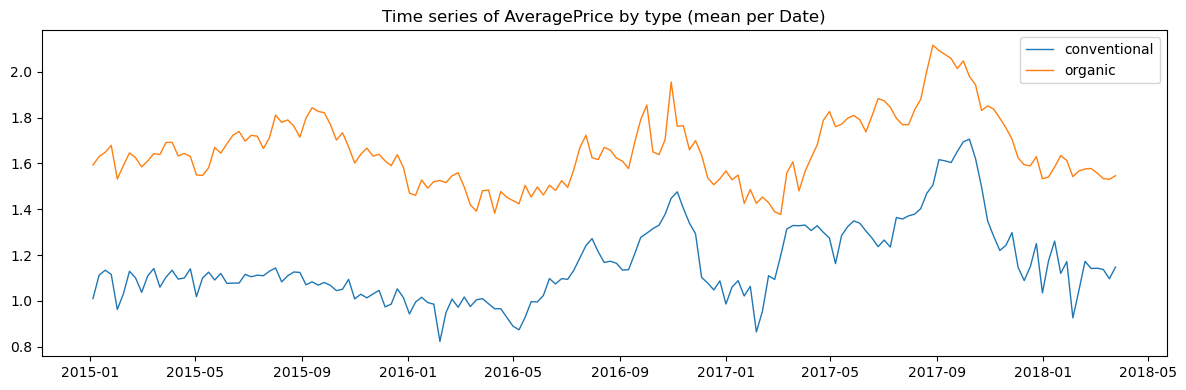

In [9]:
plt.figure(figsize=(12,4))
if 'Date' in df.columns:
    for t in types_sorted:
        ser = df[df['type'] == t].dropna(subset=['Date','AveragePrice']).groupby('Date')['AveragePrice'].mean()
        if ser.empty:
            continue
        plt.plot(ser.index, ser.values, linewidth=1, label=labels.get(t, str(t)))
    plt.legend()
    plt.title('Time series of AveragePrice by type (mean per Date)')
    plt.tight_layout()
    plt.show()
else:
    print("No 'Date' column found.")

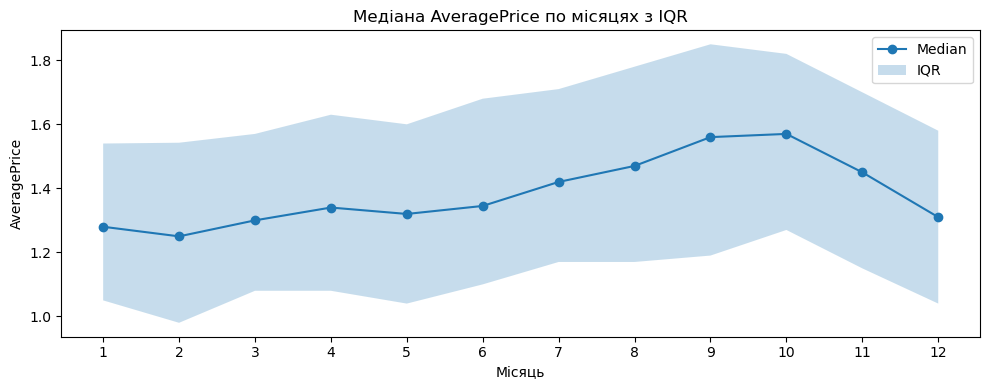

In [10]:
if 'month' in df.columns:
    monthly = df.groupby('month')['AveragePrice'].agg(['median','count'])
    q1 = df.groupby('month')['AveragePrice'].quantile(0.25)
    q3 = df.groupby('month')['AveragePrice'].quantile(0.75)
    monthly['q1'] = q1
    monthly['q3'] = q3

    plt.figure(figsize=(10,4))
    months = monthly.index
    plt.plot(months, monthly['median'], marker='o', label='Median')
    plt.fill_between(months, monthly['q1'], monthly['q3'], alpha=0.25, label='IQR')
    plt.xticks(range(1,13))
    plt.xlabel('Місяць')
    plt.ylabel('AveragePrice')
    plt.title('Медіана AveragePrice по місяцях з IQR')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No 'month' column — створіть її з Date перед запуском.")

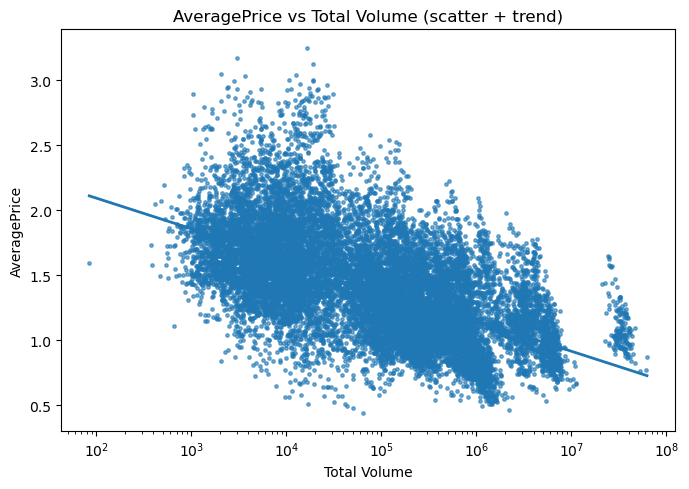

In [11]:
plt.figure(figsize=(7,5))
mask = df['Total Volume'].notna() & df['AveragePrice'].notna() & (df['Total Volume'] > 0)
if mask.any():
    x = df.loc[mask, 'Total Volume']
    y = df.loc[mask, 'AveragePrice']
    plt.scatter(x, y, s=6, alpha=0.6)
    z = np.polyfit(np.log1p(x), y, 1)
    xp = np.linspace(x.min(), x.max(), 100)
    plt.plot(xp, np.polyval(z, np.log1p(xp)), linewidth=2)
    plt.xscale('log')
    plt.title('AveragePrice vs Total Volume (scatter + trend)')
    plt.xlabel('Total Volume')
    plt.ylabel('AveragePrice')
    plt.tight_layout()
    plt.show()
else:
    print("No positive Total Volume data for scatter.")

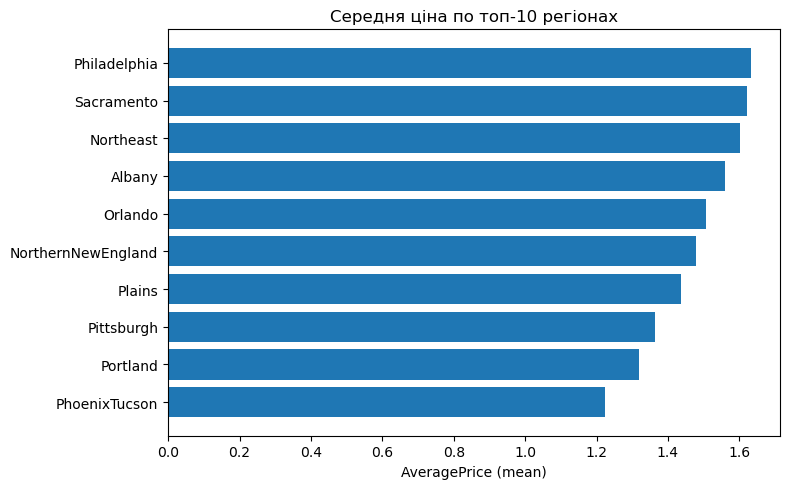

In [12]:
# Середня ціна по топ-10 регіонах
if 'region' in df.columns:
    top_regions = df['region'].value_counts().nlargest(10).index.tolist()
    mean_by_region = df[df['region'].isin(top_regions)].groupby('region')['AveragePrice'].mean().sort_values()
    if not mean_by_region.empty:
        plt.figure(figsize=(8,5))
        plt.barh(mean_by_region.index, mean_by_region.values)
        plt.xlabel('AveragePrice (mean)')
        plt.title('Середня ціна по топ-10 регіонах')
        plt.tight_layout()
        plt.show()
    else:
        print("Mean by region empty.")
else:
    print("No 'region' column.")


Числові колонки: ['AveragePrice', 'Total Volume', 'PLU_4046', 'PLU_4225', 'PLU_4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'month', 'week', 'month_sin', 'month_cos']


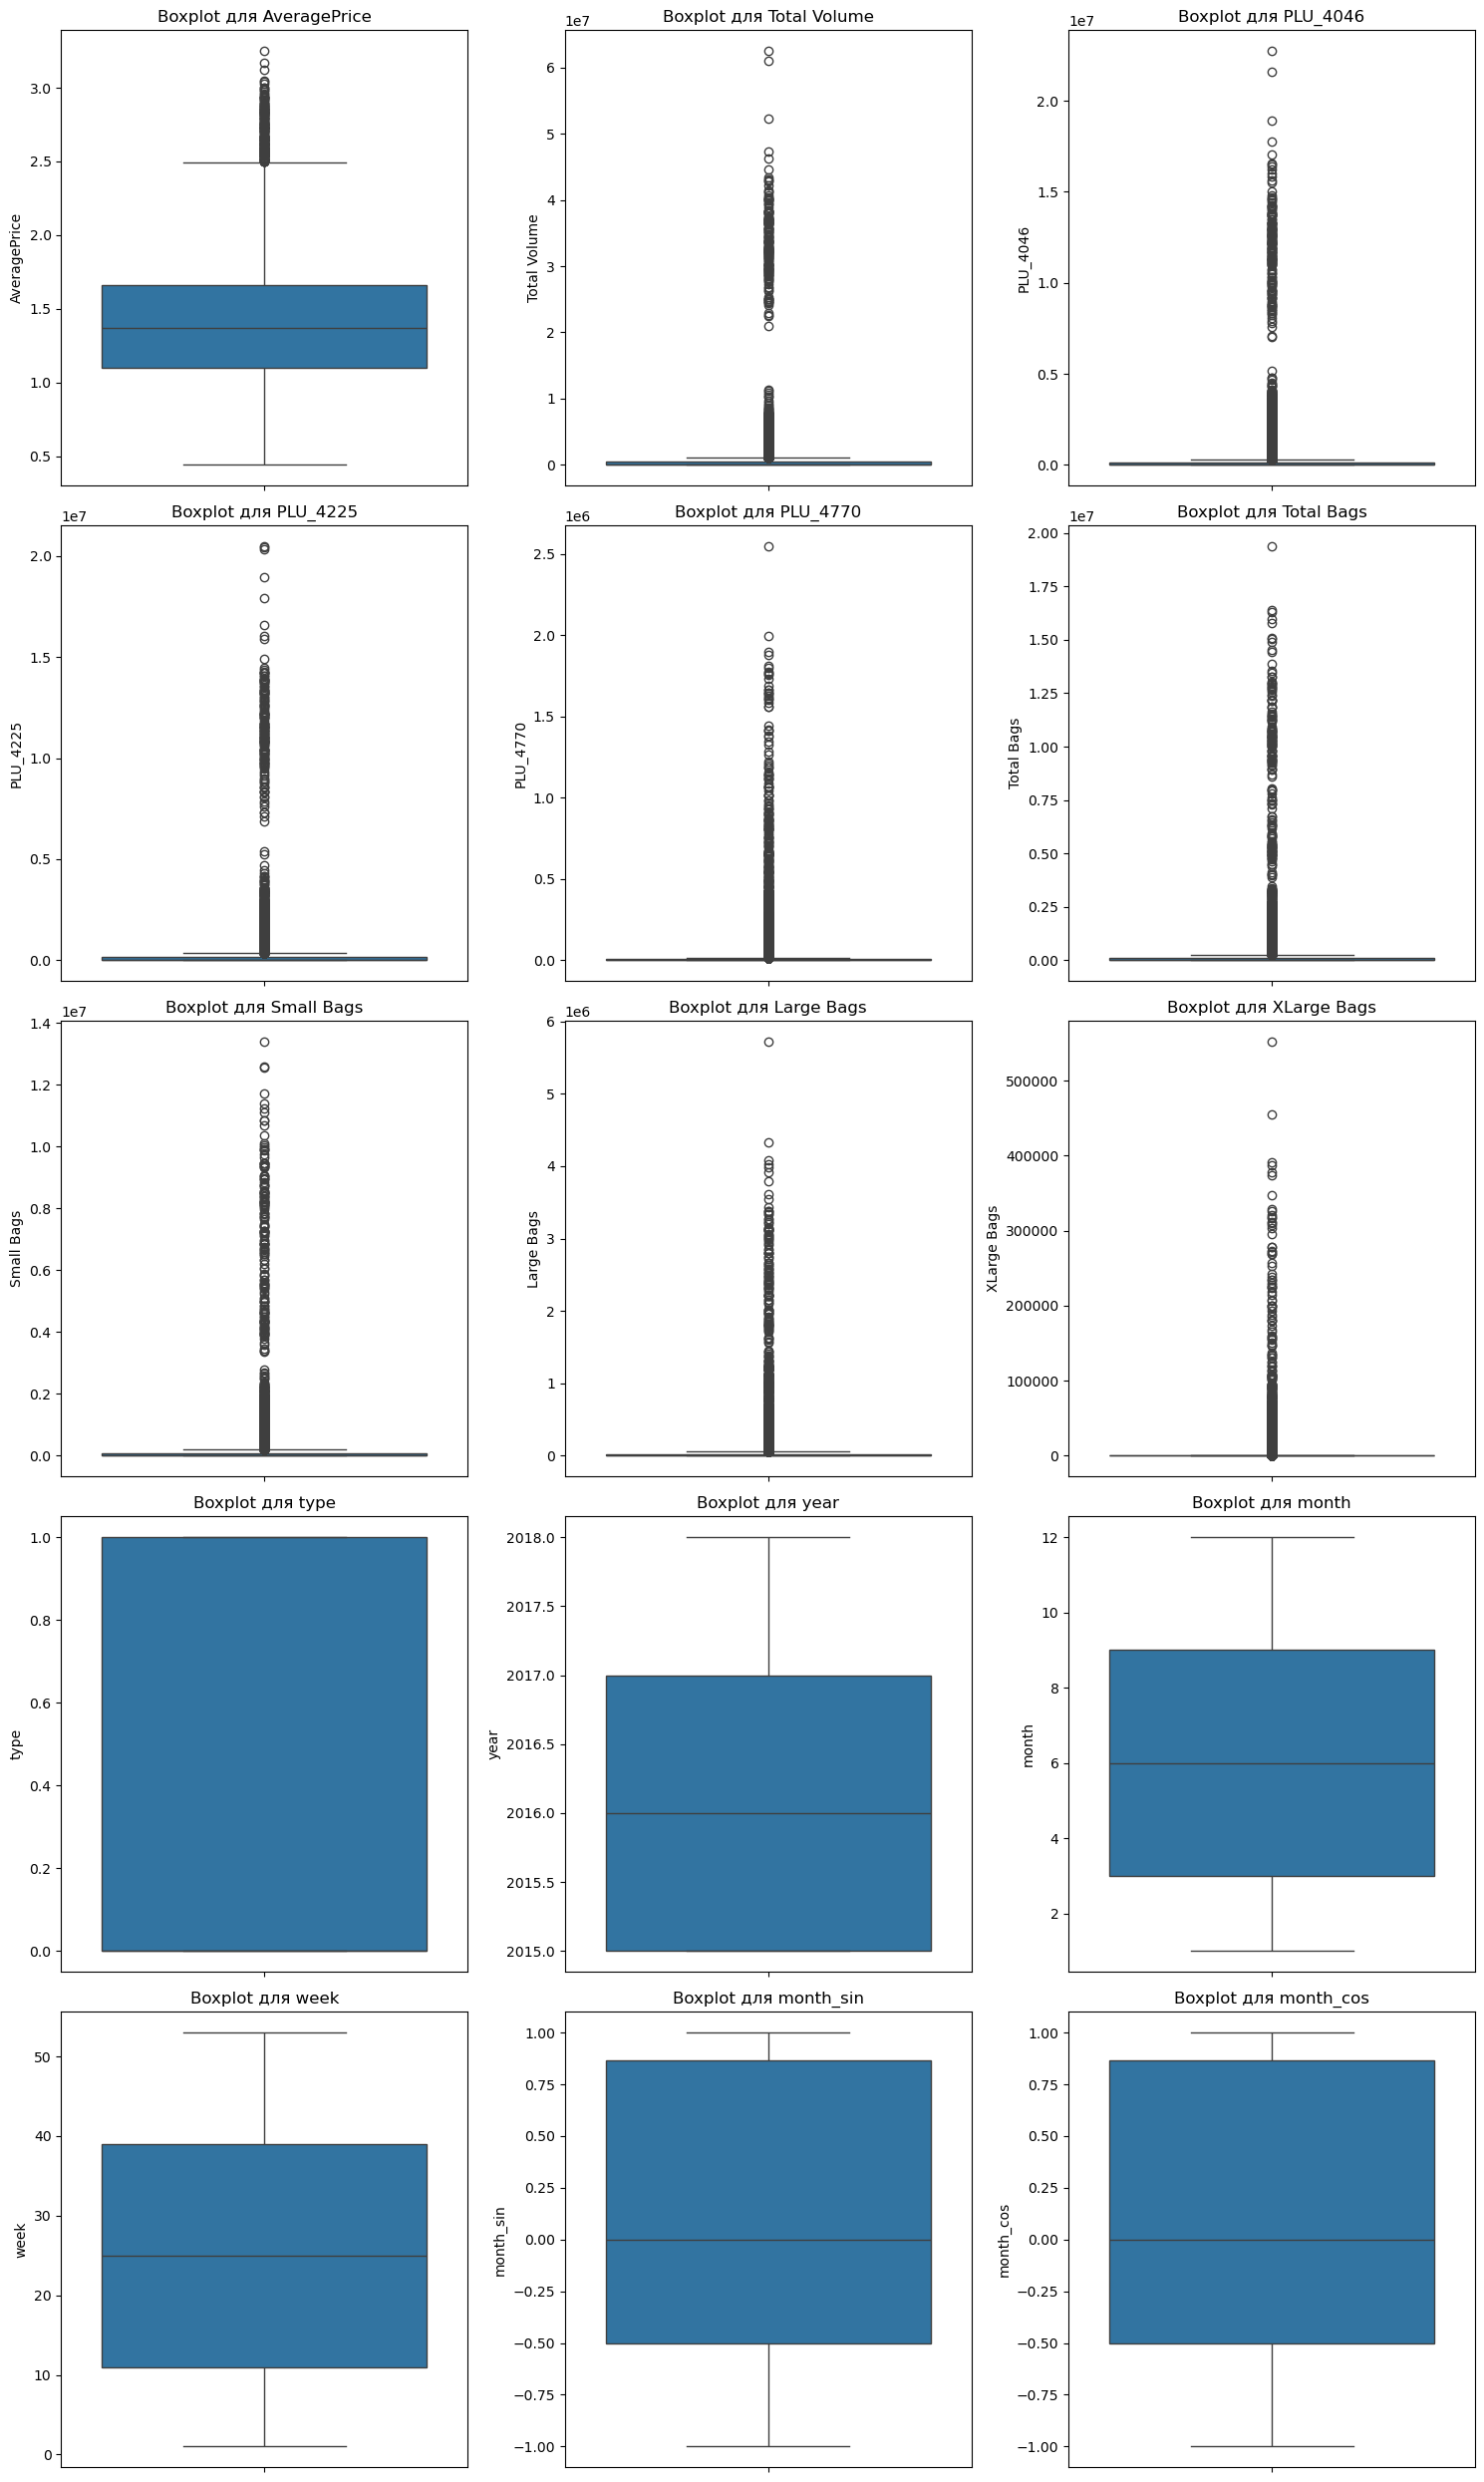

<Figure size 640x480 with 0 Axes>

In [13]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Виведення списку числових колонок для перевірки
print("Числові колонки:", list(numeric_cols))

# Створення subplot для кожного boxplot (наприклад, 3x4 сітка, залежно від кількості колонок)
num_cols = len(numeric_cols)
nrows = (num_cols + 2) // 3  # Автоматичний розрахунок рядків для 3 колонок у рядку
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Перетворення в 1D масив для зручності

# Цикл для створення boxplot для кожної числової колонки
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot для {col}')
    axes[i].set_ylabel(col)

# Приховування зайвих axes, якщо є
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

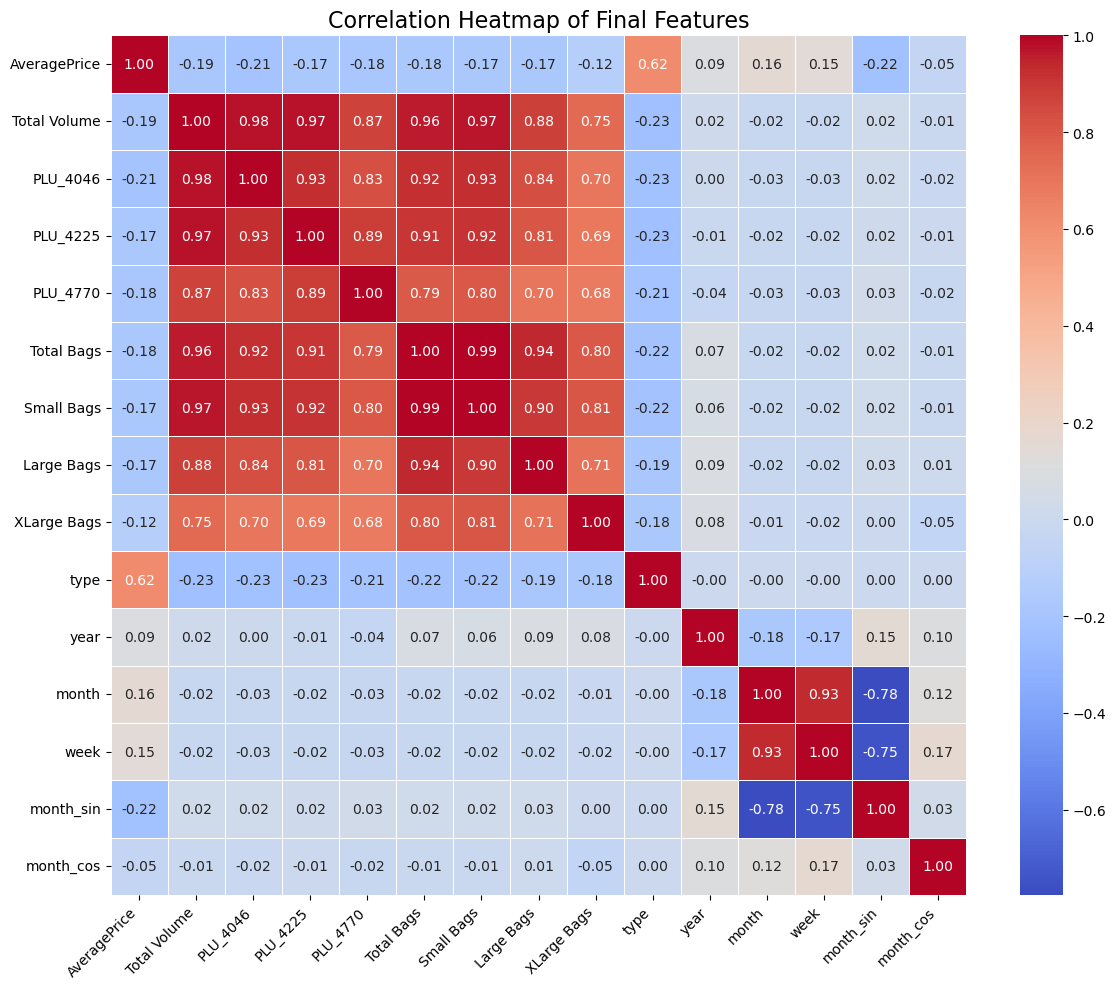

In [14]:
#Heatmap кореляційної матриці
numeric_df = df.select_dtypes(include=['number'])

# Розраховуємо повну матрицю кореляцій
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10)) # Adjust size for better readability

sns.heatmap(
    corr_matrix,
    annot=True,       # Display the correlation values on the map
    fmt='.2f',        # Format values to two decimal places
    cmap='coolwarm',  # Use a diverging colormap (blue-white-red)
    linewidths=.5     # Add lines to separate cells
)

plt.title('Correlation Heatmap of Final Features', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate labels for better fit
plt.yticks(rotation=0)
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()


In [15]:
unique_regions = sorted(df['region'].unique())
print(unique_regions)

['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', 'BuffaloRochester', 'California', 'Charlotte', 'Chicago', 'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver', 'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton', 'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville', 'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale', 'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork', 'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia', 'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland', 'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento', 'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina', 'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse', 'Tampa', 'TotalUS', 'West', 'WestTexNewMexico']


In [16]:
import numpy as np
import pandas as pd
from typing import Optional
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# -------------------------
# Custom Target+Frequency encoder (minimal, safe)
# -------------------------
class TargetFreqEncoder(BaseEstimator, TransformerMixin):
    """
    Fit: compute target mean per category and frequency (relative) on X (single-col) with y.
    Transform: map categories to [target_mean, freq] (2 columns). Unknown categories -> global mean / 0.0
    """
    def __init__(self, col_name: Optional[str] = None):
        self.col_name = col_name

    def fit(self, X, y):
        # Accept pandas Series/DataFrame or numpy array
        if isinstance(X, pd.DataFrame):
            s = X.iloc[:, 0].reset_index(drop=True)
        else:
            s = pd.Series(np.asarray(X).ravel())
        y = pd.Series(y).reset_index(drop=True)

        df_tmp = pd.DataFrame({'cat': s, 'y': y})
        agg = df_tmp.groupby('cat')['y'].agg(['mean', 'count']).rename(columns={'mean':'cat_mean','count':'cat_count'})
        agg['freq'] = agg['cat_count'] / len(df_tmp)

        self.global_mean_ = float(y.mean())
        self.mapping_mean_ = agg['cat_mean'].to_dict()
        self.mapping_freq_ = agg['freq'].to_dict()
        self.fitted_ = True
        return self

    def transform(self, X):
        if not getattr(self, 'fitted_', False):
            raise RuntimeError("Encoder must be fitted before transform.")
        if isinstance(X, pd.DataFrame):
            s = X.iloc[:, 0]
        else:
            s = pd.Series(np.asarray(X).ravel())
        te = s.map(self.mapping_mean_).fillna(self.global_mean_).astype(float).values
        fr = s.map(self.mapping_freq_).fillna(0.0).astype(float).values
        return np.vstack([te, fr]).T

    def get_feature_names_out(self, input_features=None):
        base = self.col_name if self.col_name is not None else (input_features[0] if input_features is not None else "region")
        return [f"{base}_te", f"{base}_freq"]


# -------------------------
# Your original pipeline with nice prints (only region encoding changed)
# -------------------------
# 1. Initial Data Preparation
data = df.copy()
data.columns = data.columns.str.strip()
print("Initial dataset shape:", data.shape)

# Drop unnecessary columns and unused aggregate regions
if 'Date' in data.columns:
    data.drop(columns=['Date', 'Total Volume', 'Total Bags', 'Unnamed: 0'], inplace=True, errors='ignore')

aggregate_regions = ['TotalUS', 'California', 'Northeast', 'SouthCentral', 'Southeast', 
                     'GreatLakes', 'Mideast', 'West', 'Plains']
before_filter_shape = data.shape
data = data[~data['region'].isin(aggregate_regions)].reset_index(drop=True)
print(f"Dropped aggregate regions (if present). Shape: {before_filter_shape} -> {data.shape}")

# Ensure 'type' numeric 0/1
if 'type' in data.columns:
    data['type'] = data['type'].map({'conventional': 0, 'organic': 1}).fillna(0).astype(int)

# 2. Feature Engineering & Transformation (placeholders as you used)
if 'year' not in data.columns:
    data['year'] = np.random.choice([2015, 2016, 2017, 2018], size=len(data))
if 'month' not in data.columns:
    data['month'] = np.random.randint(1, 13, size=len(data))
if 'week' not in data.columns:
    data['week'] = np.random.randint(1, 53, size=len(data))
data['month_sin'] = np.sin(2 * np.pi * data['month']/12.0)
data['month_cos'] = np.cos(2 * np.pi * data['month']/12.0)

# Apply safe log transform if columns exist
log_cols = ['PLU_4046', 'PLU_4225', 'PLU_4770', 'Small Bags', 'Large Bags', 'XLarge Bags']
for col in log_cols:
    if col in data.columns:
        data[col] = np.log1p(np.clip(data[col].astype(float), a_min=0, a_max=None))

# Rename Bag columns
data.rename(columns={'Small Bags': 'Small_Bags', 'Large Bags': 'Large_Bags', 'XLarge Bags': 'XLarge_Bags'}, inplace=True)

# 3. Outlier Removal (IQR clipping)
def remove_outliers_iqr_clip(df, column, factor=1.5):
    if column not in df.columns or not np.issubdtype(df[column].dtype, np.number):
        return df
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    df2 = df.copy()
    df2[column] = np.clip(df2[column], lower, upper)
    return df2

outlier_cols = ['AveragePrice', 'PLU_4046', 'PLU_4225', 'PLU_4770', 'Small_Bags', 'Large_Bags', 'XLarge_Bags']
initial_shape = data.shape
for col in outlier_cols:
    data = remove_outliers_iqr_clip(data, col)
print(f"After IQR clipping on {len(outlier_cols)} cols: {initial_shape} -> {data.shape}")

# 4. Define features, target and preprocessor (RESTORED)
features = ['PLU_4046', 'PLU_4225', 'PLU_4770',
            'Small_Bags', 'Large_Bags', 'XLarge_Bags',
            'type', 'region', 'year', 'week', 'month',
            'month_sin', 'month_cos']
X = data[features].copy()
y = data['AveragePrice'].copy()

# Train/holdout split
X_main, X_holdout, y_main, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
print("="*65)
print("Data Split into Main (Training/CV) and Hold-out (Final Test) Sets")
print("="*65)
print(f"Total initial samples: {len(X)}")
print(f"Main set for Training & CV (80%):      X_main shape: {X_main.shape}")
print(f"Hold-out set for Final Test (20%):     X_holdout shape: {X_holdout.shape}")
print("-" * 65)
print(f"Main target shape: {y_main.shape}, Holdout target shape: {y_holdout.shape}")
print("="*65)

# Determine numeric & categorical (for ColumnTransformer)
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Build preprocessor: keep numeric scaling, replace OneHot for region with TargetFreqEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('region_enc', TargetFreqEncoder(col_name='region'), ['region'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# 5. Apply Preprocessing Across All Folds with informative prints
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preprocessed_folds = {}

print("\n" + "="*80)
print("Applying Preprocessing to All Folds for Cross-Validation (Target+Freq encoding for 'region')")
print("="*80)

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_main, y_main)):
    print(f"\n--- Fold {fold_idx+1}/5 — splitting data ---")
    X_train, X_test = X_main.iloc[train_index].copy(), X_main.iloc[test_index].copy()
    y_train, y_test = y_main.iloc[train_index].copy(), y_main.iloc[test_index].copy()
    print(f"  Raw shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")

    # Fit preprocessor on training data (pass y_train so encoder learns target mapping)
    print("  Fitting preprocessor on TRAIN (numeric scaling + target+freq encoding for 'region')...")
    X_train_pre = preprocessor.fit_transform(X_train, y_train)
    print("  Transforming TEST with fitted preprocessor...")
    X_test_pre = preprocessor.transform(X_test)

    # Build output column names
    num_out = numeric_features
    region_out = preprocessor.named_transformers_['region_enc'].get_feature_names_out(['region'])
    out_cols = list(num_out) + list(region_out)

    # Convert to DataFrame for readability
    X_train_pre_df = pd.DataFrame(X_train_pre, columns=out_cols, index=X_train.index).reset_index(drop=True)
    X_test_pre_df = pd.DataFrame(X_test_pre, columns=out_cols, index=X_test.index).reset_index(drop=True)

    # Save to dict
    preprocessed_folds[f'fold_{fold_idx}'] = {
        'X_train': X_train_pre_df,
        'y_train': y_train.reset_index(drop=True),
        'X_test': X_test_pre_df,
        'y_test': y_test.reset_index(drop=True),
        'preprocessor': preprocessor
    }

    # Nicely formatted diagnostics
    print(f"  -> Preprocessed shapes: X_train: {X_train_pre_df.shape} | X_test: {X_test_pre_df.shape}")
    print(f"  -> Output columns ({len(out_cols)}): {out_cols}")
    print("  -> Sample (first 3 rows) of preprocessed X_train:")
    print(X_train_pre_df.head(3).to_string(index=False))
    print("  -> y_train sample (first 5):", y_train.reset_index(drop=True).head(5).tolist())

print("\n" + "="*80)
print("All folds preprocessed. Access example: preprocessed_folds['fold_0']['X_train']")
print(f"Fold 0 preprocessed shape: {preprocessed_folds['fold_0']['X_train'].shape}")
print("="*80)

Initial dataset shape: (18249, 17)
Dropped aggregate regions (if present). Shape: (18249, 14) -> (15545, 14)
After IQR clipping on 7 cols: (15545, 14) -> (15545, 14)
Data Split into Main (Training/CV) and Hold-out (Final Test) Sets
Total initial samples: 15545
Main set for Training & CV (80%):      X_main shape: (12436, 13)
Hold-out set for Final Test (20%):     X_holdout shape: (3109, 13)
-----------------------------------------------------------------
Main target shape: (12436,), Holdout target shape: (3109,)
Numeric features: ['PLU_4046', 'PLU_4225', 'PLU_4770', 'Small_Bags', 'Large_Bags', 'XLarge_Bags', 'type', 'year', 'week', 'month', 'month_sin', 'month_cos']
Categorical features: ['region']

Applying Preprocessing to All Folds for Cross-Validation (Target+Freq encoding for 'region')

--- Fold 1/5 — splitting data ---
  Raw shapes: X_train=(9948, 13), X_test=(2488, 13), y_train=(9948,), y_test=(2488,)
  Fitting preprocessor on TRAIN (numeric scaling + target+freq encoding for 'r

In [17]:

import time
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Діапазон кількості нейронів для експерименту (динамічне додавання)
neuron_counts = [5, 10, 20, 50, 100, 150, 200, 300, 500]

# Збереження результатів для кожної конфігурації
results = {
    'neurons': [],
    'train_rmse': [],
    'train_mae': [],
    'train_r2': [],
    'test_rmse': [],
    'test_mae': [],
    'test_r2': [],
    'overfitting': [],
    'training_time': [],
    'n_iterations': []  # Кількість ітерацій до збіжності
}


# Експерименти з різною кількістю нейронів
for n_neurons in neuron_counts:
    print(f"\n{'='*70}")
    print(f"Тестування конфігурації: 1 прихований шар з {n_neurons} нейронами")
    print(f"{'='*70}")
    
    fold_train_rmse = []
    fold_train_mae = []
    fold_train_r2 = []
    fold_test_rmse = []
    fold_test_mae = []
    fold_test_r2 = []
    fold_times = []
    fold_iterations = []
    
    # Крос-валідація на 5 фолдах
    for i in range(len(preprocessed_folds)):
        fold_data = preprocessed_folds[f'fold_{i}']
        X_train, y_train = fold_data['X_train'], fold_data['y_train']
        X_test, y_test = fold_data['X_test'], fold_data['y_test']
        
        # Модель з поточною кількістю нейронів
        mlp = MLPRegressor(
            hidden_layer_sizes=(n_neurons,),  # Одношарова архітектура
            activation='relu',                 # ReLU активація
            solver='adam',                     # Adam оптимізатор
            alpha=0.0001,                      # L2 регуляризація
            batch_size='auto',
            learning_rate='adaptive',          # Адаптивний learning rate
            learning_rate_init=0.001,
            max_iter=1000,                     # Максимум ітерацій
            random_state=42,
            early_stopping=True,               # Рання зупинка
            validation_fraction=0.1,           # 10% train → валідація
            n_iter_no_change=20,               # Терпіння для early stopping
            verbose=False
        )
        
        # Навчання з вимірюванням часу
        start_time = time.time()
        mlp.fit(X_train, y_train)
        training_time = time.time() - start_time
        fold_times.append(training_time)
        fold_iterations.append(mlp.n_iter_)
        
        # Оцінка на train
        y_train_pred = mlp.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        
        # Оцінка на test
        y_test_pred = mlp.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        fold_train_rmse.append(train_rmse)
        fold_train_mae.append(train_mae)
        fold_train_r2.append(train_r2)
        fold_test_rmse.append(test_rmse)
        fold_test_mae.append(test_mae)
        fold_test_r2.append(test_r2)
        
        print(f"  Фолд {i+1}: Train R²={train_r2:.4f} | Test R²={test_r2:.4f} | "
              f"Test RMSE={test_rmse:.4f} | Час={training_time:.2f}s | Ітерацій={mlp.n_iter_}")
    
    # Середні значення по всіх фолдах
    avg_train_rmse = np.mean(fold_train_rmse)
    avg_train_mae = np.mean(fold_train_mae)
    avg_train_r2 = np.mean(fold_train_r2)
    avg_test_rmse = np.mean(fold_test_rmse)
    avg_test_mae = np.mean(fold_test_mae)
    avg_test_r2 = np.mean(fold_test_r2)
    avg_time = np.mean(fold_times)
    avg_iterations = np.mean(fold_iterations)
    
    # Стандартні відхилення
    std_test_rmse = np.std(fold_test_rmse)
    std_test_r2 = np.std(fold_test_r2)
    
    # Індикатор перенавчання
    overfitting_score = (avg_train_r2 - avg_test_r2) / avg_train_r2 * 100 if avg_train_r2 > 0 else 0
    
    # Збереження результатів
    results['neurons'].append(n_neurons)
    results['train_rmse'].append(avg_train_rmse)
    results['train_mae'].append(avg_train_mae)
    results['train_r2'].append(avg_train_r2)
    results['test_rmse'].append(avg_test_rmse)
    results['test_mae'].append(avg_test_mae)
    results['test_r2'].append(avg_test_r2)
    results['overfitting'].append(overfitting_score)
    results['training_time'].append(avg_time)
    results['n_iterations'].append(avg_iterations)
    
    print(f"\n  Середні результати для {n_neurons} нейронів:")
    print(f"    Train: RMSE={avg_train_rmse:.4f}, MAE={avg_train_mae:.4f}, R²={avg_train_r2:.4f}")
    print(f"    Test:  RMSE={avg_test_rmse:.4f} (±{std_test_rmse:.4f}), MAE={avg_test_mae:.4f}, R²={avg_test_r2:.4f} (±{std_test_r2:.4f})")
    print(f"    Overfitting: {overfitting_score:.2f}%")
    print(f"    Час навчання: {avg_time:.2f}s | Середня к-сть ітерацій: {avg_iterations:.0f}")

# ============================================================================
# Підсумкова таблиця результатів
# ============================================================================

print("\n" + "="*130)
print("ПІДСУМКОВА ТАБЛИЦЯ РЕЗУЛЬТАТІВ: Одношарові мережі")
print("="*130)
print(f"{'Нейрони':<10} {'Train RMSE':<12} {'Test RMSE':<12} {'Train MAE':<12} "
      f"{'Test MAE':<12} {'Train R²':<10} {'Test R²':<10} {'Overfitting%':<15} {'Час(s)':<10}")
print("-"*130)

for i in range(len(results['neurons'])):
    print(f"{results['neurons'][i]:<10} "
          f"{results['train_rmse'][i]:<12.4f} "
          f"{results['test_rmse'][i]:<12.4f} "
          f"{results['train_mae'][i]:<12.4f} "
          f"{results['test_mae'][i]:<12.4f} "
          f"{results['train_r2'][i]:<10.4f} "
          f"{results['test_r2'][i]:<10.4f} "
          f"{results['overfitting'][i]:<15.2f} "
          f"{results['training_time'][i]:<10.2f}")

# ============================================================================
# Аналіз оптимальної конфігурації
# ============================================================================

# Критерії для вибору оптимальної моделі
best_idx_r2 = np.argmax(results['test_r2'])  # Максимальний R² на тесті
best_idx_rmse = np.argmin(results['test_rmse'])  # Мінімальний RMSE на тесті

# Знайдемо компромісну конфігурацію (висока якість + низьке перенавчання)
# Фільтруємо тільки моделі з overfitting < 5%
good_models = [(i, results['test_r2'][i], results['overfitting'][i]) 
               for i in range(len(results['neurons'])) 
               if results['overfitting'][i] < 5]

if good_models:
    optimal_idx = max(good_models, key=lambda x: x[1])[0]  # Максимальний R² серед "хороших"
else:
    optimal_idx = best_idx_r2  # Якщо всі мають overfitting >5%, беремо найкращий R²

print("АНАЛІЗ РЕЗУЛЬТАТІВ ТА ВИБІР ОПТИМАЛЬНОЇ МОДЕЛІ")


print(f"\n  Найкраща модель за Test R² (максимальна точність):")
print(f"   Нейронів:        {results['neurons'][best_idx_r2]}")
print(f"   Test R²:         {results['test_r2'][best_idx_r2]:.4f}")
print(f"   Test RMSE:       {results['test_rmse'][best_idx_r2]:.4f}")
print(f"   Test MAE:        {results['test_mae'][best_idx_r2]:.4f}")
print(f"   Overfitting:     {results['overfitting'][best_idx_r2]:.2f}%")
print(f"   Час навчання:    {results['training_time'][best_idx_r2]:.2f}s")

if results['overfitting'][best_idx_r2] < 5:
    print(f"  Оцінка: Відмінна генералізація")
elif results['overfitting'][best_idx_r2] < 15:
    print(f"   Оцінка: Помірне перенавчання")
else:
    print(f"  Оцінка: Значне перенавчання")

print(f"\n Оптимальна модель (компроміс точність/генералізація):")
print(f"   Нейронів:        {results['neurons'][optimal_idx]}")
print(f"   Test R²:         {results['test_r2'][optimal_idx]:.4f}")
print(f"   Test RMSE:       {results['test_rmse'][optimal_idx]:.4f}")
print(f"   Test MAE:        {results['test_mae'][optimal_idx]:.4f}")
print(f"   Overfitting:     {results['overfitting'][optimal_idx]:.2f}%")
print(f"   Час навчання:    {results['training_time'][optimal_idx]:.2f}s")
print(f"   Оцінка: Оптимальний баланс")

# Аналіз тренду
print(f"\n Аналіз динаміки додавання нейронів:")
print(f"   • Мінімальна конфігурація (5 нейронів):  Test R² = {results['test_r2'][0]:.4f}")
print(f"   • Максимальна конфігурація (500 нейронів): Test R² = {results['test_r2'][-1]:.4f}")
print(f"   • Покращення: {((results['test_r2'][-1] - results['test_r2'][0]) / results['test_r2'][0] * 100):+.2f}%")

# Визначаємо, де відбувається насичення (diminishing returns)
improvements = []
for i in range(1, len(results['test_r2'])):
    improvement = results['test_r2'][i] - results['test_r2'][i-1]
    improvements.append(improvement)

max_improvement_idx = np.argmax(improvements)
print(f"\n   • Найбільше покращення між {results['neurons'][max_improvement_idx]} та "
      f"{results['neurons'][max_improvement_idx + 1]} нейронами: "
      f"{improvements[max_improvement_idx]:+.4f} R²")

# Знаходимо точку насичення (коли покращення < 0.01)
saturation_point = None
for i, improvement in enumerate(improvements):
    if improvement < 0.01:
        saturation_point = i
        break

if saturation_point:
    print(f"   • Точка насичення (покращення < 0.01): ~{results['neurons'][saturation_point]} нейронів")
else:
    print(f"   • Точка насичення не досягнута - можна спробувати більше нейронів")


# Збереження найкращої моделі для подальшого використання
best_n_neurons = results['neurons'][optimal_idx]

final_mlp = MLPRegressor(
    hidden_layer_sizes=(best_n_neurons,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)

# Підготовка holdout даних
preprocessor_final = preprocessed_folds['fold_0']['preprocessor']
X_main_processed = preprocessor_final.fit_transform(X_main, y_main)

# Отримуємо назви колонок
numeric_features = X_main.select_dtypes(include=np.number).columns.tolist()
region_out = preprocessor_final.named_transformers_['region_enc'].get_feature_names_out(['region'])
out_cols = list(numeric_features) + list(region_out)

X_main_processed_df = pd.DataFrame(X_main_processed, columns=out_cols)

# Навчання фінальної моделі
final_mlp.fit(X_main_processed_df, y_main)

# Оцінка на holdout
X_holdout_processed = preprocessor_final.transform(X_holdout)
X_holdout_processed_df = pd.DataFrame(X_holdout_processed, columns=out_cols)

y_holdout_pred = final_mlp.predict(X_holdout_processed_df)

holdout_rmse = np.sqrt(mean_squared_error(y_holdout, y_holdout_pred))
holdout_mae = mean_absolute_error(y_holdout, y_holdout_pred)
holdout_r2 = r2_score(y_holdout, y_holdout_pred)

print(f"\n Фінальна модель навчена!")
print(f"   Архітектура: ({best_n_neurons},) нейронів")
print(f"   Кількість ітерацій: {final_mlp.n_iter_}")
print(f"\n Результати на незалежному holdout наборі:")
print(f"   RMSE:  {holdout_rmse:.4f}")
print(f"   MAE:   {holdout_mae:.4f}")
print(f"   R²:    {holdout_r2:.4f}")

# Порівняння з CV результатами
cv_test_r2 = results['test_r2'][optimal_idx]
generalization_diff = ((holdout_r2 - cv_test_r2) / cv_test_r2) * 100

print(f"\n Порівняння CV vs Holdout:")
print(f"   CV Test R²:      {cv_test_r2:.4f}")
print(f"   Holdout R²:      {holdout_r2:.4f}")
print(f"   Різниця:         {generalization_diff:+.2f}%")

if abs(generalization_diff) < 2:
    print(f"    Відмінна узгодженість - модель стабільна!")
elif abs(generalization_diff) < 5:
    print(f"    Прийнятна узгодженість")
else:
    print(f"    Значна розбіжність - можлива нестабільність")




Тестування конфігурації: 1 прихований шар з 5 нейронами
  Фолд 1: Train R²=0.6706 | Test R²=0.6642 | Test RMSE=0.2345 | Час=2.24s | Ітерацій=328
  Фолд 2: Train R²=0.6860 | Test R²=0.6671 | Test RMSE=0.2290 | Час=2.89s | Ітерацій=427
  Фолд 3: Train R²=0.6682 | Test R²=0.6409 | Test RMSE=0.2378 | Час=1.95s | Ітерацій=249
  Фолд 4: Train R²=0.6830 | Test R²=0.6805 | Test RMSE=0.2288 | Час=2.70s | Ітерацій=376
  Фолд 5: Train R²=0.6769 | Test R²=0.6854 | Test RMSE=0.2301 | Час=3.85s | Ітерацій=575

  Середні результати для 5 нейронів:
    Train: RMSE=0.2289, MAE=0.1785, R²=0.6770
    Test:  RMSE=0.2320 (±0.0036), MAE=0.1812, R²=0.6676 (±0.0156)
    Overfitting: 1.38%
    Час навчання: 2.72s | Середня к-сть ітерацій: 391

Тестування конфігурації: 1 прихований шар з 10 нейронами
  Фолд 1: Train R²=0.7510 | Test R²=0.7404 | Test RMSE=0.2062 | Час=1.63s | Ітерацій=205
  Фолд 2: Train R²=0.7535 | Test R²=0.7386 | Test RMSE=0.2029 | Час=1.70s | Ітерацій=214
  Фолд 3: Train R²=0.7538 | Test R²

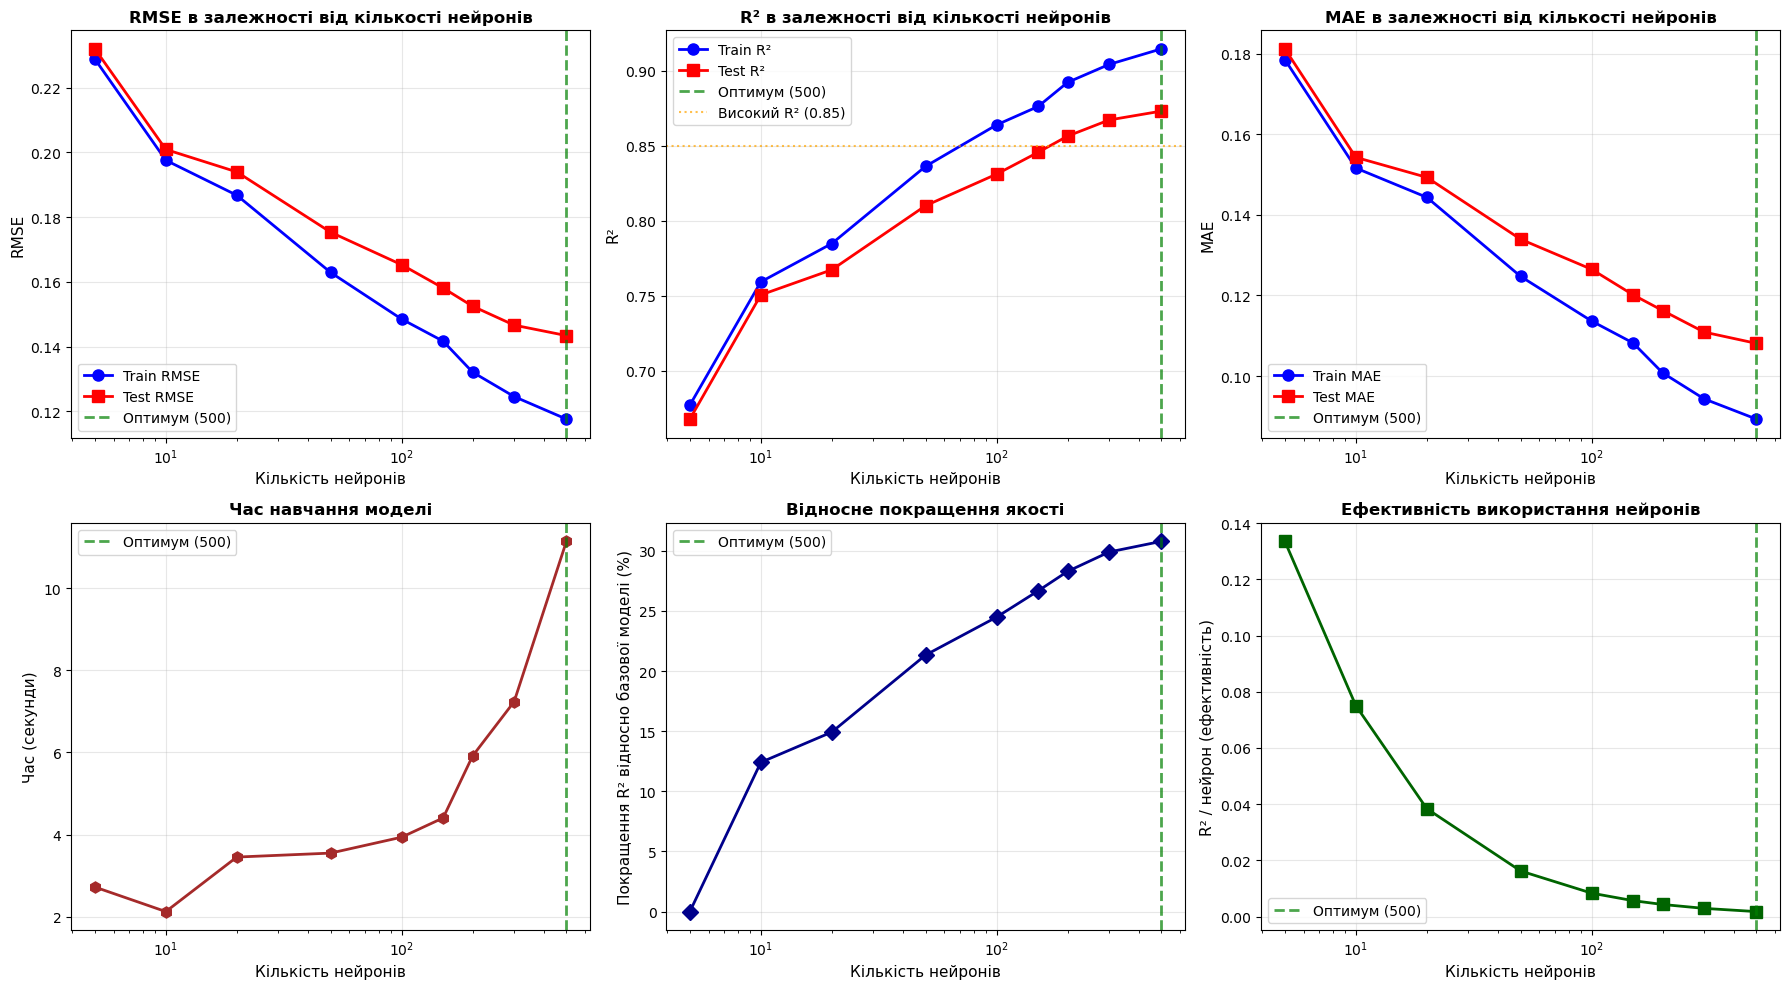

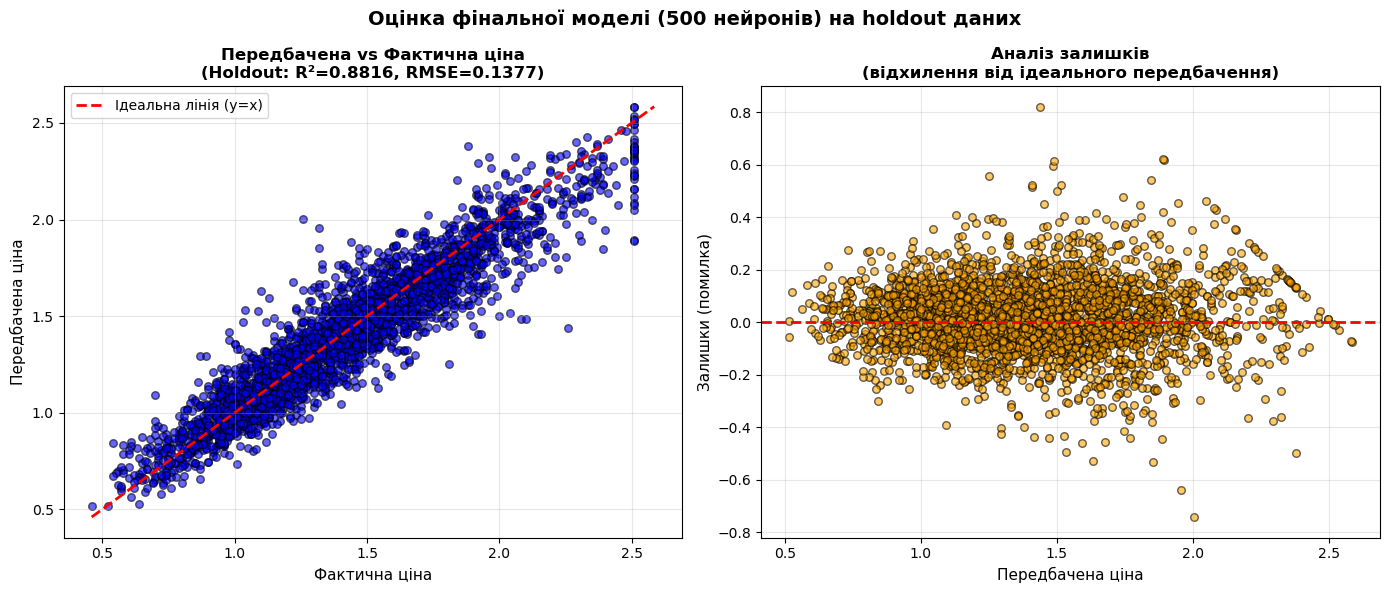

In [18]:
# ============================================================================
# ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ ЕКСПЕРИМЕНТІВ
# ============================================================================

import matplotlib.pyplot as plt

# Створення головної фігури з 6 графіками
fig, axes = plt.subplots(2, 3, figsize=(18, 10))


# ============================================================================
# RMSE vs Кількість нейронів
# ============================================================================
axes[0, 0].plot(results['neurons'], results['train_rmse'], 'o-', 
                label='Train RMSE', linewidth=2, markersize=8, color='blue')
axes[0, 0].plot(results['neurons'], results['test_rmse'], 's-', 
                label='Test RMSE', linewidth=2, markersize=8, color='red')
axes[0, 0].axvline(x=results['neurons'][optimal_idx], color='green', 
                   linestyle='--', linewidth=2, alpha=0.7, label=f'Оптимум ({results["neurons"][optimal_idx]})')
axes[0, 0].set_xlabel('Кількість нейронів', fontsize=11)
axes[0, 0].set_ylabel('RMSE', fontsize=11)
axes[0, 0].set_title('RMSE в залежності від кількості нейронів', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log')

# ============================================================================
# R² vs Кількість нейронів
# ============================================================================
axes[0, 1].plot(results['neurons'], results['train_r2'], 'o-', 
                label='Train R²', linewidth=2, markersize=8, color='blue')
axes[0, 1].plot(results['neurons'], results['test_r2'], 's-', 
                label='Test R²', linewidth=2, markersize=8, color='red')
axes[0, 1].axvline(x=results['neurons'][optimal_idx], color='green', 
                   linestyle='--', linewidth=2, alpha=0.7, label=f'Оптимум ({results["neurons"][optimal_idx]})')
axes[0, 1].axhline(y=0.85, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label='Високий R² (0.85)')
axes[0, 1].set_xlabel('Кількість нейронів', fontsize=11)
axes[0, 1].set_ylabel('R²', fontsize=11)
axes[0, 1].set_title('R² в залежності від кількості нейронів', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')

# ============================================================================
# MAE vs Кількість нейронів
# ============================================================================
axes[0, 2].plot(results['neurons'], results['train_mae'], 'o-', 
                label='Train MAE', linewidth=2, markersize=8, color='blue')
axes[0, 2].plot(results['neurons'], results['test_mae'], 's-', 
                label='Test MAE', linewidth=2, markersize=8, color='red')
axes[0, 2].axvline(x=results['neurons'][optimal_idx], color='green', 
                   linestyle='--', linewidth=2, alpha=0.7, label=f'Оптимум ({results["neurons"][optimal_idx]})')
axes[0, 2].set_xlabel('Кількість нейронів', fontsize=11)
axes[0, 2].set_ylabel('MAE', fontsize=11)
axes[0, 2].set_title('MAE в залежності від кількості нейронів', fontsize=12, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xscale('log')



# ============================================================================
# Час навчання vs Кількість нейронів
# ============================================================================
axes[1, 0].plot(results['neurons'], results['training_time'], 'h-', 
                color='brown', linewidth=2, markersize=8)
axes[1, 0].axvline(x=results['neurons'][optimal_idx], color='green', 
                   linestyle='--', linewidth=2, alpha=0.7, label=f'Оптимум ({results["neurons"][optimal_idx]})')
axes[1, 0].set_xlabel('Кількість нейронів', fontsize=11)
axes[1, 0].set_ylabel('Час (секунди)', fontsize=11)
axes[1, 0].set_title('Час навчання моделі', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')

# Додавання значень для оптимальної точки
for ax in axes.flat:
    opt_x = results['neurons'][optimal_idx]
    # Знаходимо y-координату для вертикальної лінії
    if 'RMSE' in ax.get_title() and 'Train' in ax.get_ylabel():
        pass  # Вже є легенда
    
plt.tight_layout()


# Відносне покращення R²
relative_improvement = [(results['test_r2'][i] - results['test_r2'][0]) / results['test_r2'][0] * 100 
                        for i in range(len(results['neurons']))]
axes[1, 1].plot(results['neurons'], relative_improvement, 'D-', 
              color='darkblue', linewidth=2, markersize=8)
axes[1, 1].axvline(x=results['neurons'][optimal_idx], color='green', 
                 linestyle='--', linewidth=2, alpha=0.7, label=f'Оптимум ({results["neurons"][optimal_idx]})')
axes[1, 1].set_xlabel('Кількість нейронів', fontsize=11)
axes[1, 1].set_ylabel('Покращення R² відносно базової моделі (%)', fontsize=11)
axes[1, 1].set_title('Відносне покращення якості', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('log')

#  Ефективність (R² на нейрон)
efficiency = [results['test_r2'][i] / results['neurons'][i] 
              for i in range(len(results['neurons']))]
axes[1, 2].plot(results['neurons'], efficiency, 's-', 
              color='darkgreen', linewidth=2, markersize=8)
axes[1, 2].axvline(x=results['neurons'][optimal_idx], color='green', 
                 linestyle='--', linewidth=2, alpha=0.7, label=f'Оптимум ({results["neurons"][optimal_idx]})')
axes[1, 2].set_xlabel('Кількість нейронів', fontsize=11)
axes[1, 2].set_ylabel('R² / нейрон (ефективність)', fontsize=11)
axes[1, 2].set_title('Ефективність використання нейронів', fontsize=12, fontweight='bold')
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xscale('log')

plt.tight_layout()
plt.show()

# ============================================================================
# Прогнози фінальної моделі на holdout
# ============================================================================
fig3, axes3 = plt.subplots(1, 2, figsize=(14, 6))
fig3.suptitle(f'Оцінка фінальної моделі ({best_n_neurons} нейронів) на holdout даних', 
              fontsize=14, fontweight='bold')

# Scatter: Передбачене vs Фактичне
axes3[0].scatter(y_holdout, y_holdout_pred, alpha=0.6, color='blue', edgecolor='k', s=30)
min_val = min(min(y_holdout), min(y_holdout_pred))
max_val = max(max(y_holdout), max(y_holdout_pred))
axes3[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ідеальна лінія (y=x)')
axes3[0].set_xlabel("Фактична ціна", fontsize=11)
axes3[0].set_ylabel("Передбачена ціна", fontsize=11)
axes3[0].set_title(f"Передбачена vs Фактична ціна\n(Holdout: R²={holdout_r2:.4f}, RMSE={holdout_rmse:.4f})", 
                   fontsize=12, fontweight='bold')
axes3[0].legend(fontsize=10)
axes3[0].grid(True, alpha=0.3)

# Аналіз залишків
residuals = y_holdout - y_holdout_pred
axes3[1].scatter(y_holdout_pred, residuals, alpha=0.6, color='orange', edgecolor='k', s=30)
axes3[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes3[1].set_xlabel("Передбачена ціна", fontsize=11)
axes3[1].set_ylabel("Залишки (помилка)", fontsize=11)
axes3[1].set_title("Аналіз залишків\n(відхилення від ідеального передбачення)", 
                   fontsize=12, fontweight='bold')
axes3[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Перевіримо як проявить себе багатошарова архітектура

In [27]:
import time
network_architectures = [
    (500, ), # - Попередній оптимум для порівняння
    # Двошарові - класичний підхід
    (64, 32),      # Пірамідальна структура (зменшення)
    (100, 50),     # Пірамідальна структура
    (80, 80),      # Однакові шари
    (50, 100),     # Зворотня піраміда (розширення)
    
    # Трьохшарові - глибоке навчання
    (128, 64, 32),   # Класична піраміда
    (100, 80, 50),   # Плавне зменшення
    (64, 64, 64),    # Однакові шари
    (50, 100, 50),   # Bottleneck архітектура
    
    # Чотиришарові - дуже глибокі мережі
    (128, 96, 64, 32),  # Поступове зменшення
    (80, 80, 80, 80),   # Рівномірна глибина
]

# Збереження результатів для кожної конфігурації
results = {
    'architecture': [],
    'n_layers': [],
    'total_neurons': [],
    'train_rmse': [],
    'train_mae': [],
    'train_r2': [],
    'test_rmse': [],
    'test_mae': [],
    'test_r2': [],
    'overfitting': [],
    'training_time': [],
    'n_iterations': []
}


# Експерименти з різними архітектурами
for architecture in network_architectures:
    arch_str = '-'.join(map(str, architecture))
    n_layers = len(architecture)
    total_neurons = sum(architecture)
    
    print(f"\n{'='*80}")
    print(f"Тестування архітектури: {arch_str} ({n_layers} шарів, {total_neurons} нейронів)")
    print(f"{'='*80}")
    
    fold_train_rmse = []
    fold_train_mae = []
    fold_train_r2 = []
    fold_test_rmse = []
    fold_test_mae = []
    fold_test_r2 = []
    fold_times = []
    fold_iterations = []
    
    # Крос-валідація на 5 фолдах
    for i in range(len(preprocessed_folds)):
        fold_data = preprocessed_folds[f'fold_{i}']
        X_train, y_train = fold_data['X_train'], fold_data['y_train']
        X_test, y_test = fold_data['X_test'], fold_data['y_test']
        
        # Модель з поточною архітектурою
        mlp = MLPRegressor(
            hidden_layer_sizes=architecture,   # Багатошарова архітектура
            activation='relu',                  # ReLU - стандарт для глибоких мереж
            solver='adam',                      # Adam - адаптивний оптимізатор
            alpha=0.0001,                       # L2 регуляризація
            batch_size='auto',                  # Автоматичний розмір батчу
            learning_rate='adaptive',           # Адаптивний learning rate
            learning_rate_init=0.001,           # Початковий learning rate
            max_iter=2000,                      # Більше ітерацій для глибших мереж
            random_state=42,
            early_stopping=True,                # Рання зупинка
            validation_fraction=0.1,            # 10% train → валідація
            n_iter_no_change=30,                # Більше терпіння для складних мереж
            tol=1e-4,                           # Критерій збіжності
            verbose=False
        )
        
        # Навчання з вимірюванням часу
        start_time = time.time()
        mlp.fit(X_train, y_train)
        training_time = time.time() - start_time
        fold_times.append(training_time)
        fold_iterations.append(mlp.n_iter_)
        
        # Оцінка на train
        y_train_pred = mlp.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        
        # Оцінка на test
        y_test_pred = mlp.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        fold_train_rmse.append(train_rmse)
        fold_train_mae.append(train_mae)
        fold_train_r2.append(train_r2)
        fold_test_rmse.append(test_rmse)
        fold_test_mae.append(test_mae)
        fold_test_r2.append(test_r2)
        
        print(f"  Фолд {i+1}: Train R²={train_r2:.4f} | Test R²={test_r2:.4f} | "
              f"Test RMSE={test_rmse:.4f} | Час={training_time:.2f}s | Ітерацій={mlp.n_iter_}")
    
    # Середні значення по всіх фолдах
    avg_train_rmse = np.mean(fold_train_rmse)
    avg_train_mae = np.mean(fold_train_mae)
    avg_train_r2 = np.mean(fold_train_r2)
    avg_test_rmse = np.mean(fold_test_rmse)
    avg_test_mae = np.mean(fold_test_mae)
    avg_test_r2 = np.mean(fold_test_r2)
    avg_time = np.mean(fold_times)
    avg_iterations = np.mean(fold_iterations)
    
    # Стандартні відхилення
    std_test_rmse = np.std(fold_test_rmse)
    std_test_r2 = np.std(fold_test_r2)
    
    # Індикатор перенавчання
    overfitting_score = (avg_train_r2 - avg_test_r2) / avg_train_r2 * 100 if avg_train_r2 > 0 else 0
    
    # Збереження результатів
    results['architecture'].append(arch_str)
    results['n_layers'].append(n_layers)
    results['total_neurons'].append(total_neurons)
    results['train_rmse'].append(avg_train_rmse)
    results['train_mae'].append(avg_train_mae)
    results['train_r2'].append(avg_train_r2)
    results['test_rmse'].append(avg_test_rmse)
    results['test_mae'].append(avg_test_mae)
    results['test_r2'].append(avg_test_r2)
    results['overfitting'].append(overfitting_score)
    results['training_time'].append(avg_time)
    results['n_iterations'].append(avg_iterations)
    
    print(f"\n  Середні результати для архітектури {arch_str}:")
    print(f"    Train: RMSE={avg_train_rmse:.4f}, MAE={avg_train_mae:.4f}, R²={avg_train_r2:.4f}")
    print(f"    Test:  RMSE={avg_test_rmse:.4f} (±{std_test_rmse:.4f}), MAE={avg_test_mae:.4f}, R²={avg_test_r2:.4f} (±{std_test_r2:.4f})")
    print(f"    Overfitting: {overfitting_score:.2f}%")
    print(f"    Час навчання: {avg_time:.2f}s | Середня к-сть ітерацій: {avg_iterations:.0f}")

# ============================================================================
# Підсумкова таблиця результатів
# ============================================================================

print("\n" + "="*140)
print("ПІДСУМКОВА ТАБЛИЦЯ РЕЗУЛЬТАТІВ: Багатошарові нейронні мережі")
print("="*140)
print(f"{'Архітектура':<20} {'Шарів':<8} {'Нейронів':<10} {'Train R²':<10} "
      f"{'Test R²':<10} {'Test RMSE':<12} {'Test MAE':<12} {'Overfitting%':<15} {'Час(s)':<10}")
print("-"*140)

for i in range(len(results['architecture'])):
    print(f"{results['architecture'][i]:<20} "
          f"{results['n_layers'][i]:<8} "
          f"{results['total_neurons'][i]:<10} "
          f"{results['train_r2'][i]:<10.4f} "
          f"{results['test_r2'][i]:<10.4f} "
          f"{results['test_rmse'][i]:<12.4f} "
          f"{results['test_mae'][i]:<12.4f} "
          f"{results['overfitting'][i]:<15.2f} "
          f"{results['training_time'][i]:<10.2f}")

# ============================================================================
# Аналіз оптимальної конфігурації
# ============================================================================

print("\n" + "="*80)
print("АНАЛІЗ РЕЗУЛЬТАТІВ ТА ВИБІР ОПТИМАЛЬНОЇ МОДЕЛІ")
print("="*80)

# Критерії для вибору оптимальної моделі
best_idx_r2 = np.argmax(results['test_r2'])
best_idx_rmse = np.argmin(results['test_rmse'])

# Знайдемо компромісну конфігурацію (висока якість + низьке перенавчання + прийнятний час)
good_models = [(i, results['test_r2'][i], results['overfitting'][i], results['training_time'][i]) 
               for i in range(len(results['architecture'])) 
               if results['overfitting'][i] < 8]  # Трохи більше допуску для складних мереж

if good_models:
    # Нормалізуємо метрики для комплексного скорингу
    r2_scores = [m[1] for m in good_models]
    time_scores = [m[3] for m in good_models]
    
    max_r2 = max(r2_scores)
    min_time = min(time_scores)
    
    # Комплексний скор: 70% точність + 30% швидкість
    scores = []
    for i, idx, r2, overfitting, t in [(i,) + m for i, m in enumerate(good_models)]:
        r2_norm = r2 / max_r2
        time_norm = min_time / t if t > 0 else 0
        composite_score = 0.7 * r2_norm + 0.3 * time_norm
        scores.append((good_models[i][0], composite_score))
    
    optimal_idx = max(scores, key=lambda x: x[1])[0]
else:
    optimal_idx = best_idx_r2

print(f"\n  1. Найкраща модель за Test R² (максимальна точність):")
print(f"     Архітектура:     {results['architecture'][best_idx_r2]}")
print(f"     Кількість шарів: {results['n_layers'][best_idx_r2]}")
print(f"     Test R²:         {results['test_r2'][best_idx_r2]:.4f}")
print(f"     Test RMSE:       {results['test_rmse'][best_idx_r2]:.4f}")
print(f"     Test MAE:        {results['test_mae'][best_idx_r2]:.4f}")
print(f"     Overfitting:     {results['overfitting'][best_idx_r2]:.2f}%")
print(f"     Час навчання:    {results['training_time'][best_idx_r2]:.2f}s")

if results['overfitting'][best_idx_r2] < 5:
    print(f"     ✓ Оцінка: Відмінна генералізація")
elif results['overfitting'][best_idx_r2] < 10:
    print(f"     → Оцінка: Помірне перенавчання")
else:
    print(f"     ✗ Оцінка: Значне перенавчання")

print(f"\n  2. Оптимальна модель (компроміс точність/генералізація/швидкість):")
print(f"     Архітектура:     {results['architecture'][optimal_idx]}")
print(f"     Кількість шарів: {results['n_layers'][optimal_idx]}")
print(f"     Test R²:         {results['test_r2'][optimal_idx]:.4f}")
print(f"     Test RMSE:       {results['test_rmse'][optimal_idx]:.4f}")
print(f"     Test MAE:        {results['test_mae'][optimal_idx]:.4f}")
print(f"     Overfitting:     {results['overfitting'][optimal_idx]:.2f}%")
print(f"     Час навчання:    {results['training_time'][optimal_idx]:.2f}s")
print(f"     ★ Оцінка: Оптимальний баланс")

# Аналіз впливу кількості шарів
print(f"\n  3. Аналіз впливу глибини мережі:")
layer_groups = {}
for i in range(len(results['architecture'])):
    n_layers = results['n_layers'][i]
    if n_layers not in layer_groups:
        layer_groups[n_layers] = []
    layer_groups[n_layers].append(results['test_r2'][i])

for n_layers in sorted(layer_groups.keys()):
    avg_r2 = np.mean(layer_groups[n_layers])
    max_r2 = np.max(layer_groups[n_layers])
    print(f"     {n_layers}-шарові мережі: середній R²={avg_r2:.4f}, максимальний R²={max_r2:.4f}")

# Порівняння архітектурних стилів
print(f"\n  4. Порівняння архітектурних стилів:")

# Пірамідальні (зменшення розміру)
pyramid_indices = [i for i, arch in enumerate(results['architecture']) 
                   if results['n_layers'][i] > 1 and 
                   all(int(x) >= int(y) for x, y in zip(arch.split('-')[:-1], arch.split('-')[1:]))]
if pyramid_indices:
    avg_pyramid_r2 = np.mean([results['test_r2'][i] for i in pyramid_indices])
    print(f"     Пірамідальні (↓):  середній R²={avg_pyramid_r2:.4f}")

# Рівномірні (однакові шари)
uniform_indices = [i for i, arch in enumerate(results['architecture'])
                   if results['n_layers'][i] > 1 and len(set(arch.split('-'))) == 1]
if uniform_indices:
    avg_uniform_r2 = np.mean([results['test_r2'][i] for i in uniform_indices])
    print(f"     Рівномірні (=):    середній R²={avg_uniform_r2:.4f}")

# Аналіз ефективності (точність vs час)
print(f"\n  5. Аналіз ефективності (точність на одиницю часу):")
efficiency_scores = []
for i in range(len(results['architecture'])):
    if results['training_time'][i] > 0:
        efficiency = results['test_r2'][i] / results['training_time'][i]
        efficiency_scores.append((i, efficiency))

efficiency_scores.sort(key=lambda x: x[1], reverse=True)
print(f"     Топ-3 найефективніших архітектур:")
for rank, (idx, score) in enumerate(efficiency_scores[:3], 1):
    print(f"       {rank}. {results['architecture'][idx]}: "
          f"R²={results['test_r2'][idx]:.4f}, Час={results['training_time'][idx]:.2f}s, "
          f"Ефективність={score:.4f}")

# ============================================================================
# Навчання фінальної моделі
# ============================================================================

print("\n" + "="*80)
print("НАВЧАННЯ ФІНАЛЬНОЇ МОДЕЛІ")
print("="*80)

# Використовуємо оптимальну архітектуру
best_architecture = tuple(map(int, results['architecture'][optimal_idx].split('-')))

final_mlp = MLPRegressor(
    hidden_layer_sizes=best_architecture,
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=2000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=30,
    tol=1e-4,
    verbose=False
)

# Підготовка holdout даних
preprocessor_final = preprocessed_folds['fold_0']['preprocessor']
X_main_processed = preprocessor_final.fit_transform(X_main, y_main)

# Отримуємо назви колонок
numeric_features = X_main.select_dtypes(include=np.number).columns.tolist()
region_out = preprocessor_final.named_transformers_['region_enc'].get_feature_names_out(['region'])
out_cols = list(numeric_features) + list(region_out)

X_main_processed_df = pd.DataFrame(X_main_processed, columns=out_cols)

# Навчання фінальної моделі
print(f"\nНавчання моделі з архітектурою {results['architecture'][optimal_idx]}...")
start_time = time.time()
final_mlp.fit(X_main_processed_df, y_main)
final_training_time = time.time() - start_time

# Оцінка на holdout
X_holdout_processed = preprocessor_final.transform(X_holdout)
X_holdout_processed_df = pd.DataFrame(X_holdout_processed, columns=out_cols)

y_holdout_pred = final_mlp.predict(X_holdout_processed_df)

holdout_rmse = np.sqrt(mean_squared_error(y_holdout, y_holdout_pred))
holdout_mae = mean_absolute_error(y_holdout, y_holdout_pred)
holdout_r2 = r2_score(y_holdout, y_holdout_pred)

print(f"\n✓ Фінальна модель успішно навчена!")
print(f"   Архітектура:     {results['architecture'][optimal_idx]}")
print(f"   Шарів:           {results['n_layers'][optimal_idx]}")
print(f"   Всього нейронів: {results['total_neurons'][optimal_idx]}")
print(f"   Ітерацій:        {final_mlp.n_iter_}")
print(f"   Час навчання:    {final_training_time:.2f}s")

print(f"\n  Результати на незалежному holdout наборі:")
print(f"   RMSE:  {holdout_rmse:.4f}")
print(f"   MAE:   {holdout_mae:.4f}")
print(f"   R²:    {holdout_r2:.4f}")

# Порівняння з CV результатами
cv_test_r2 = results['test_r2'][optimal_idx]
generalization_diff = ((holdout_r2 - cv_test_r2) / cv_test_r2) * 100 if cv_test_r2 != 0 else 0

print(f"\n  Порівняння CV vs Holdout:")
print(f"   CV Test R²:      {cv_test_r2:.4f}")
print(f"   Holdout R²:      {holdout_r2:.4f}")
print(f"   Різниця:         {generalization_diff:+.2f}%")

if abs(generalization_diff) < 2:
    print(f"   ✓ Відмінна узгодженість - модель дуже стабільна!")
elif abs(generalization_diff) < 5:
    print(f"   → Прийнятна узгодженість - модель стабільна")
else:
    print(f"   ✗ Значна розбіжність - можлива нестабільність")

# Додатковий аналіз ваг мережі
print(f"\n  Аналіз структури навченої мережі:")
for i, (coef, intercept) in enumerate(zip(final_mlp.coefs_, final_mlp.intercepts_)):
    if i == 0:
        print(f"   Шар 1 (вхідний → прихований): {coef.shape[0]} → {coef.shape[1]} зв'язків")
    elif i == len(final_mlp.coefs_) - 1:
        print(f"   Шар {i+1} (прихований → вихідний): {coef.shape[0]} → {coef.shape[1]} зв'язків")
    else:
        print(f"   Шар {i+1} (прихований → прихований): {coef.shape[0]} → {coef.shape[1]} зв'язків")
    
total_params = sum(coef.size + intercept.size for coef, intercept in zip(final_mlp.coefs_, final_mlp.intercepts_))
print(f"\n   Загальна кількість параметрів: {total_params:,}")

print("\n" + "="*80)
print("ЕКСПЕРИМЕНТ ЗАВЕРШЕНО")
print("="*80)


Тестування архітектури: 500 (1 шарів, 500 нейронів)
  Фолд 1: Train R²=0.9241 | Test R²=0.8789 | Test RMSE=0.1408 | Час=17.30s | Ітерацій=270
  Фолд 2: Train R²=0.9179 | Test R²=0.8698 | Test RMSE=0.1432 | Час=11.22s | Ітерацій=191
  Фолд 3: Train R²=0.9172 | Test R²=0.8756 | Test RMSE=0.1400 | Час=12.88s | Ітерацій=221
  Фолд 4: Train R²=0.9279 | Test R²=0.8742 | Test RMSE=0.1435 | Час=16.11s | Ітерацій=271
  Фолд 5: Train R²=0.9088 | Test R²=0.8745 | Test RMSE=0.1454 | Час=10.25s | Ітерацій=172

  Середні результати для архітектури 500:
    Train: RMSE=0.1144, MAE=0.0867, R²=0.9192
    Test:  RMSE=0.1426 (±0.0020), MAE=0.1072, R²=0.8746 (±0.0029)
    Overfitting: 4.85%
    Час навчання: 13.55s | Середня к-сть ітерацій: 225

Тестування архітектури: 64-32 (2 шарів, 96 нейронів)
  Фолд 1: Train R²=0.8801 | Test R²=0.8483 | Test RMSE=0.1576 | Час=3.88s | Ітерацій=189
  Фолд 2: Train R²=0.8959 | Test R²=0.8417 | Test RMSE=0.1579 | Час=4.53s | Ітерацій=228
  Фолд 3: Train R²=0.9008 | Test

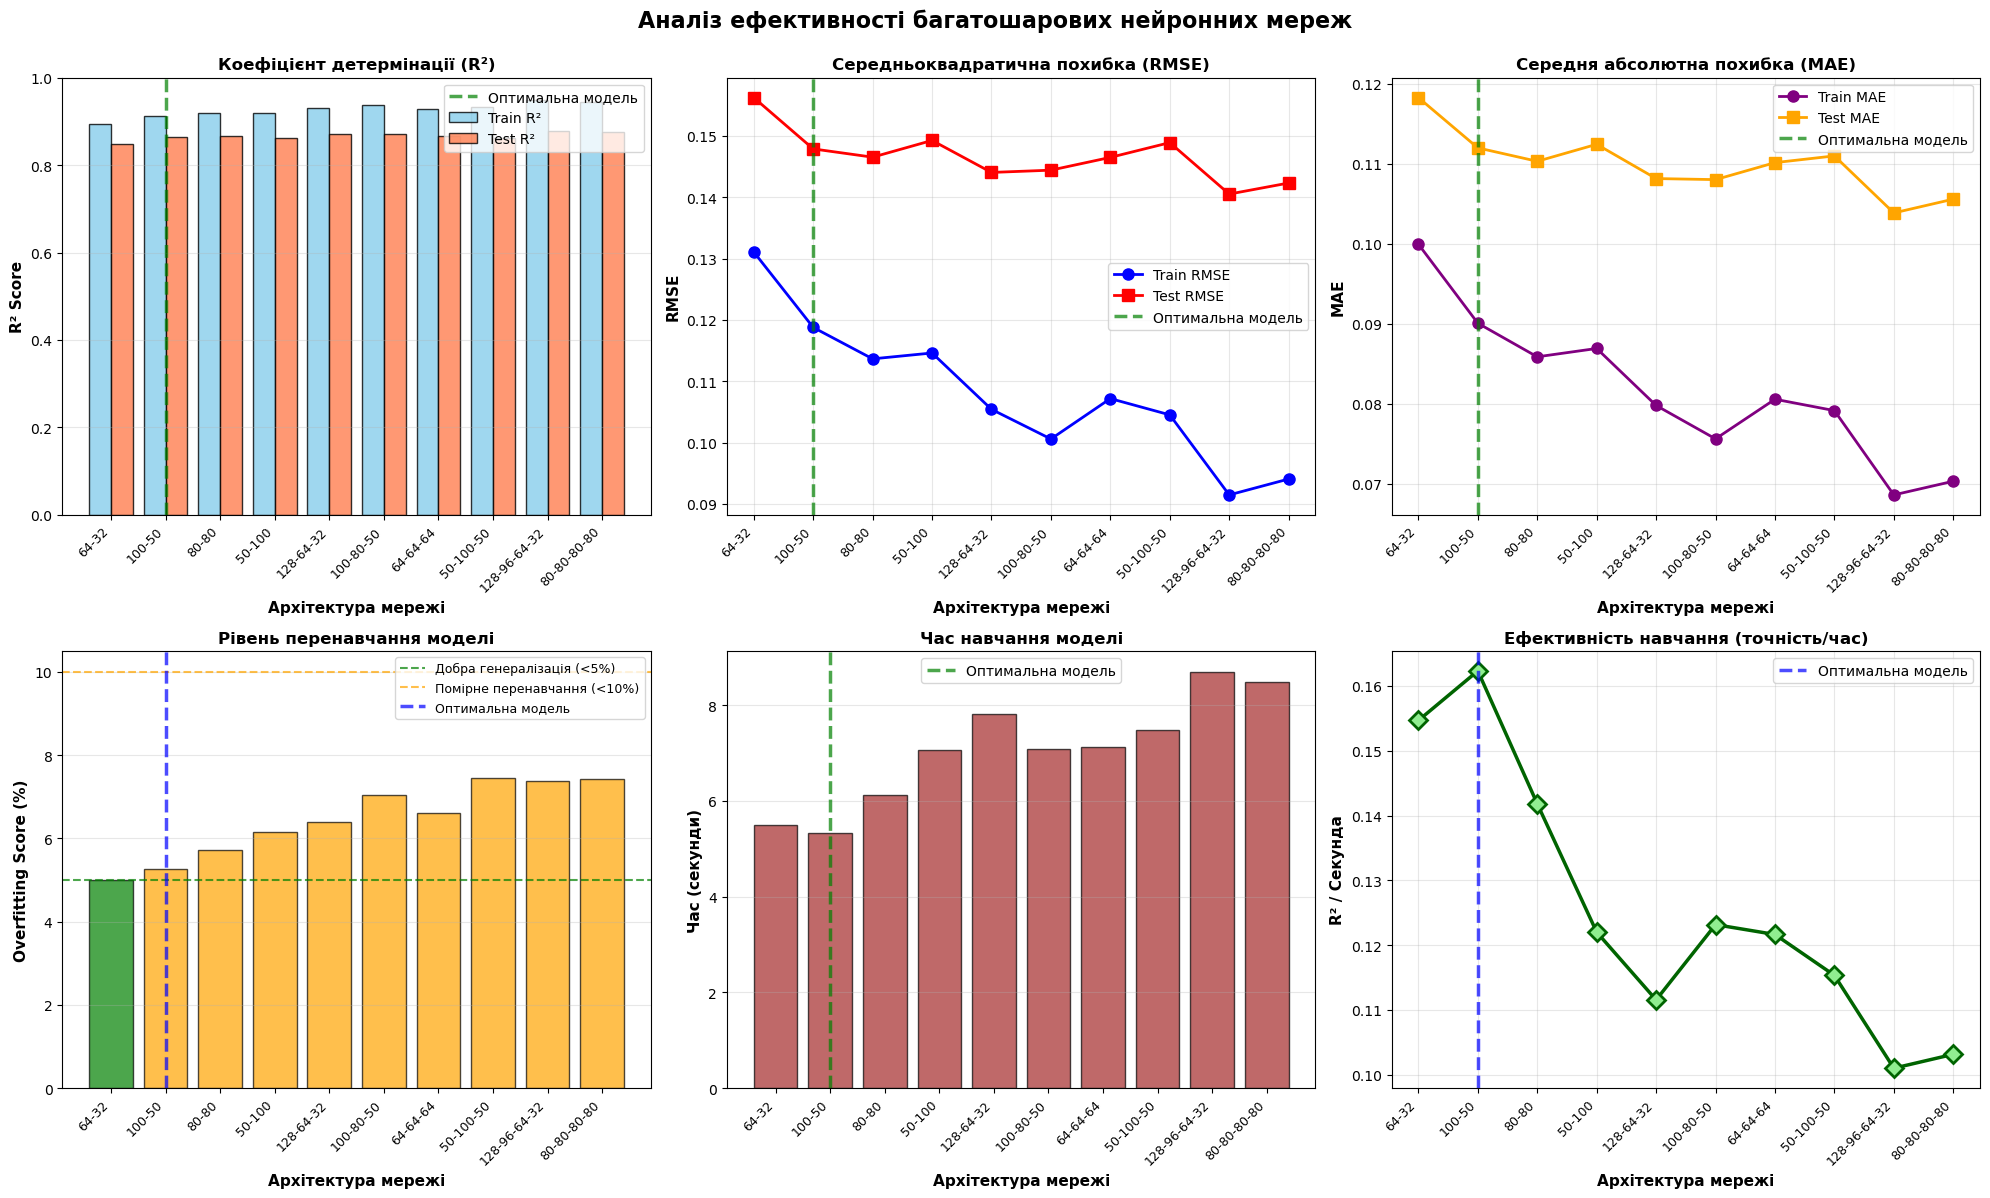

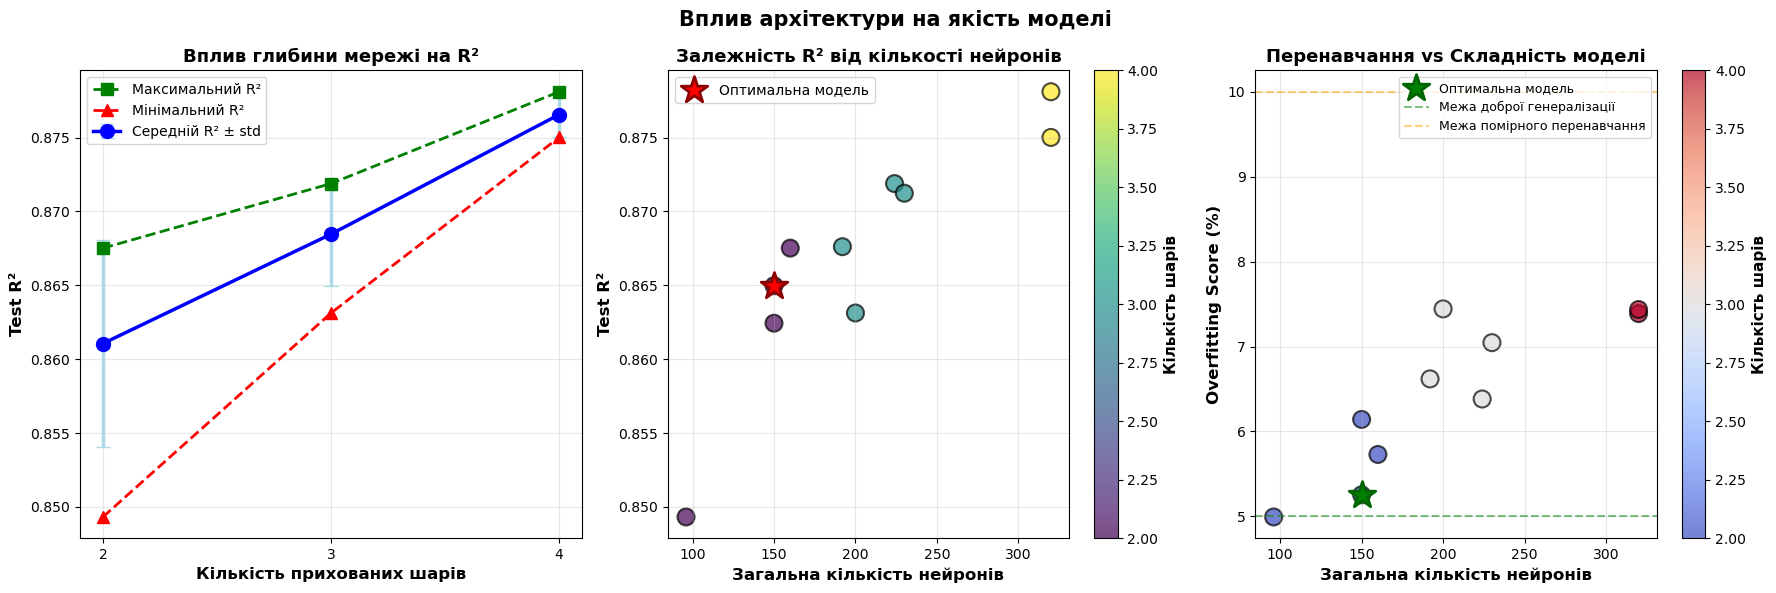

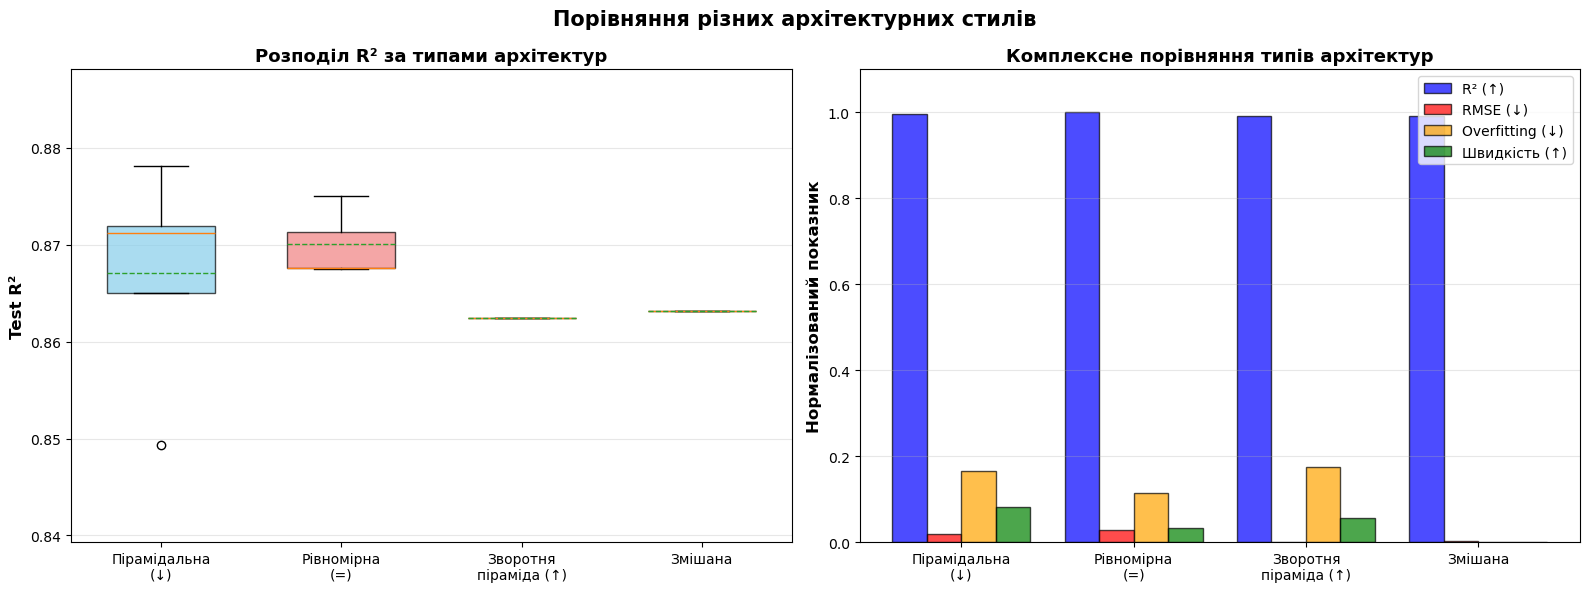

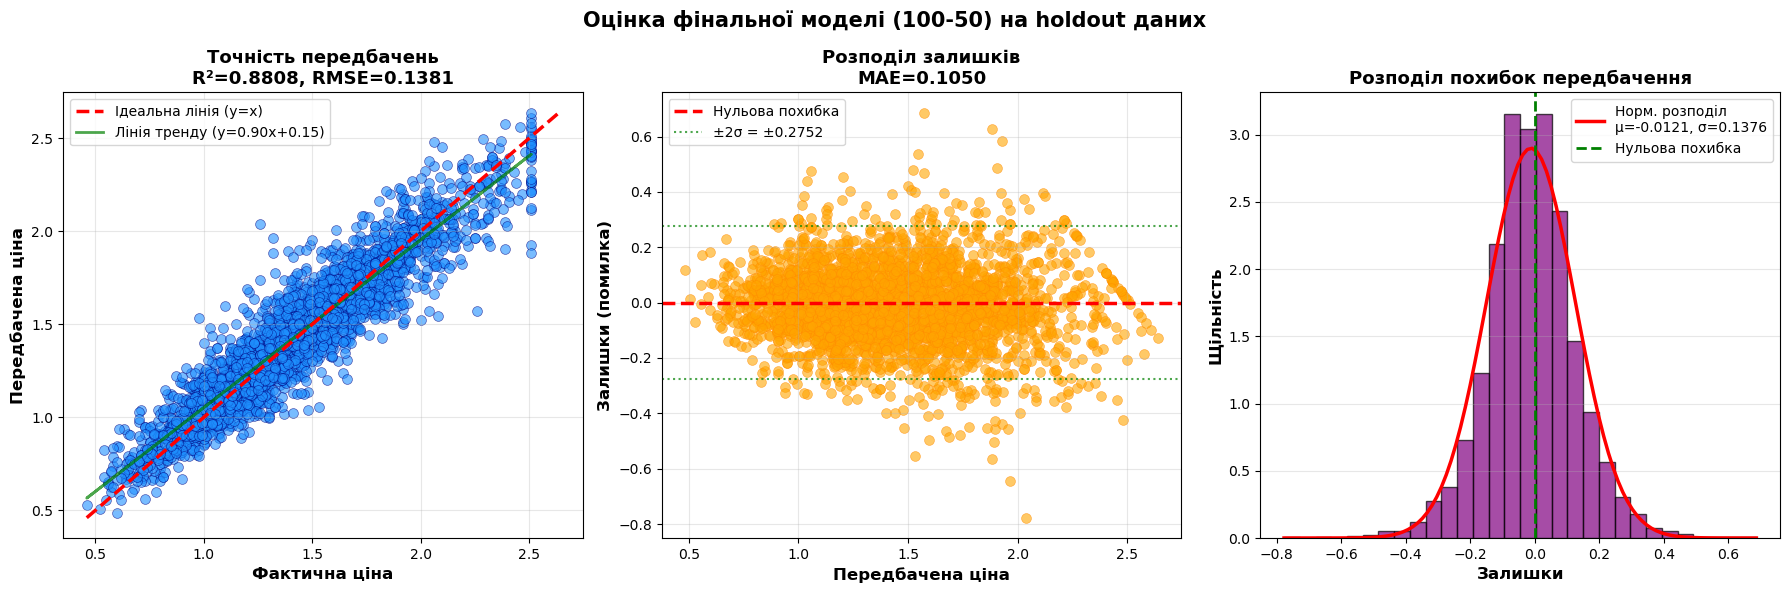

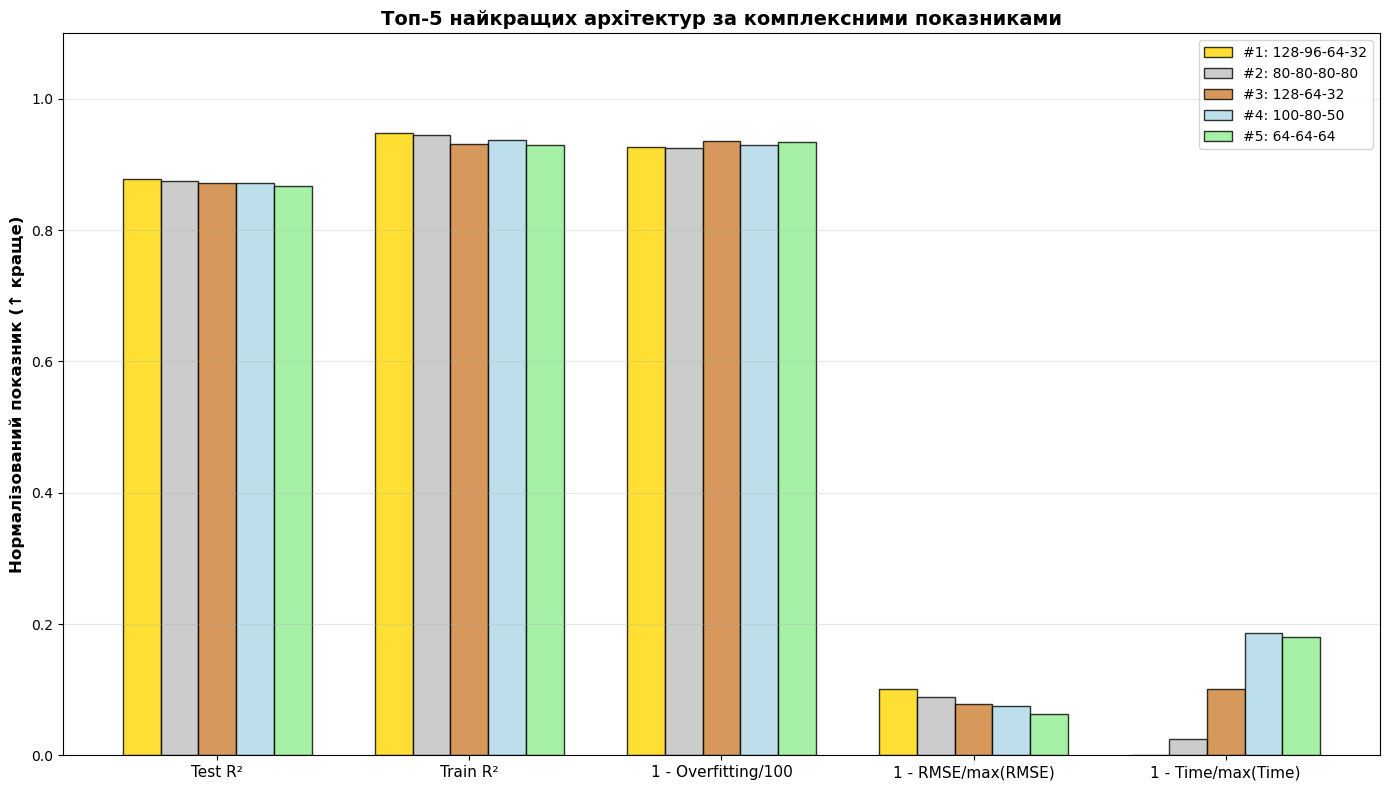


✓ ВСІ ВІЗУАЛІЗАЦІЇ СТВОРЕНО!
Графік 1: Порівняння всіх метрик для 10 архітектур
Графік 2: Вплив кількості шарів та нейронів на якість
Графік 3: Порівняння різних типів архітектур
Графік 4: Оцінка фінальної моделі на holdout даних
Графік 5: Топ-5 найкращих архітектур


In [24]:
# ============================================================================
# ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ ЕКСПЕРИМЕНТІВ З БАГАТОШАРОВИМИ МЕРЕЖАМИ
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# ГРАФІК 1: Порівняння метрик для різних архітектур
# ============================================================================
fig1, axes1 = plt.subplots(2, 3, figsize=(20, 12))
fig1.suptitle('Аналіз ефективності багатошарових нейронних мереж', 
              fontsize=16, fontweight='bold', y=0.995)

# Підготовка даних для візуалізації
x_labels = results['architecture']
x_pos = np.arange(len(x_labels))

# 1.1 R² для Train та Test
axes1[0, 0].bar(x_pos - 0.2, results['train_r2'], 0.4, 
                label='Train R²', color='skyblue', alpha=0.8, edgecolor='black')
axes1[0, 0].bar(x_pos + 0.2, results['test_r2'], 0.4, 
                label='Test R²', color='coral', alpha=0.8, edgecolor='black')
axes1[0, 0].axvline(x=optimal_idx, color='green', linestyle='--', 
                    linewidth=2.5, alpha=0.7, label='Оптимальна модель')
axes1[0, 0].set_xlabel('Архітектура мережі', fontsize=11, fontweight='bold')
axes1[0, 0].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes1[0, 0].set_title('Коефіцієнт детермінації (R²)', fontsize=12, fontweight='bold')
axes1[0, 0].set_xticks(x_pos)
axes1[0, 0].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes1[0, 0].legend(fontsize=10)
axes1[0, 0].grid(True, alpha=0.3, axis='y')
axes1[0, 0].set_ylim([0, 1])

# 1.2 RMSE для Train та Test
axes1[0, 1].plot(x_pos, results['train_rmse'], 'o-', 
                 label='Train RMSE', linewidth=2, markersize=8, color='blue')
axes1[0, 1].plot(x_pos, results['test_rmse'], 's-', 
                 label='Test RMSE', linewidth=2, markersize=8, color='red')
axes1[0, 1].axvline(x=optimal_idx, color='green', linestyle='--', 
                    linewidth=2.5, alpha=0.7, label='Оптимальна модель')
axes1[0, 1].set_xlabel('Архітектура мережі', fontsize=11, fontweight='bold')
axes1[0, 1].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes1[0, 1].set_title('Середньоквадратична похибка (RMSE)', fontsize=12, fontweight='bold')
axes1[0, 1].set_xticks(x_pos)
axes1[0, 1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes1[0, 1].legend(fontsize=10)
axes1[0, 1].grid(True, alpha=0.3)

# 1.3 MAE для Train та Test
axes1[0, 2].plot(x_pos, results['train_mae'], 'o-', 
                 label='Train MAE', linewidth=2, markersize=8, color='purple')
axes1[0, 2].plot(x_pos, results['test_mae'], 's-', 
                 label='Test MAE', linewidth=2, markersize=8, color='orange')
axes1[0, 2].axvline(x=optimal_idx, color='green', linestyle='--', 
                    linewidth=2.5, alpha=0.7, label='Оптимальна модель')
axes1[0, 2].set_xlabel('Архітектура мережі', fontsize=11, fontweight='bold')
axes1[0, 2].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes1[0, 2].set_title('Середня абсолютна похибка (MAE)', fontsize=12, fontweight='bold')
axes1[0, 2].set_xticks(x_pos)
axes1[0, 2].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes1[0, 2].legend(fontsize=10)
axes1[0, 2].grid(True, alpha=0.3)

# 1.4 Overfitting Score
colors_overfitting = ['green' if x < 5 else 'orange' if x < 10 else 'red' 
                      for x in results['overfitting']]
axes1[1, 0].bar(x_pos, results['overfitting'], color=colors_overfitting, 
                alpha=0.7, edgecolor='black')
axes1[1, 0].axhline(y=5, color='green', linestyle='--', linewidth=1.5, 
                    alpha=0.7, label='Добра генералізація (<5%)')
axes1[1, 0].axhline(y=10, color='orange', linestyle='--', linewidth=1.5, 
                    alpha=0.7, label='Помірне перенавчання (<10%)')
axes1[1, 0].axvline(x=optimal_idx, color='blue', linestyle='--', 
                    linewidth=2.5, alpha=0.7, label='Оптимальна модель')
axes1[1, 0].set_xlabel('Архітектура мережі', fontsize=11, fontweight='bold')
axes1[1, 0].set_ylabel('Overfitting Score (%)', fontsize=11, fontweight='bold')
axes1[1, 0].set_title('Рівень перенавчання моделі', fontsize=12, fontweight='bold')
axes1[1, 0].set_xticks(x_pos)
axes1[1, 0].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes1[1, 0].legend(fontsize=9)
axes1[1, 0].grid(True, alpha=0.3, axis='y')

# 1.5 Час навчання
axes1[1, 1].bar(x_pos, results['training_time'], color='brown', 
                alpha=0.7, edgecolor='black')
axes1[1, 1].axvline(x=optimal_idx, color='green', linestyle='--', 
                    linewidth=2.5, alpha=0.7, label='Оптимальна модель')
axes1[1, 1].set_xlabel('Архітектура мережі', fontsize=11, fontweight='bold')
axes1[1, 1].set_ylabel('Час (секунди)', fontsize=11, fontweight='bold')
axes1[1, 1].set_title('Час навчання моделі', fontsize=12, fontweight='bold')
axes1[1, 1].set_xticks(x_pos)
axes1[1, 1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes1[1, 1].legend(fontsize=10)
axes1[1, 1].grid(True, alpha=0.3, axis='y')

# 1.6 Ефективність (R² / час)
efficiency = [results['test_r2'][i] / results['training_time'][i] 
              if results['training_time'][i] > 0 else 0 
              for i in range(len(results['architecture']))]
axes1[1, 2].plot(x_pos, efficiency, 'D-', color='darkgreen', 
                 linewidth=2.5, markersize=9, markerfacecolor='lightgreen', 
                 markeredgecolor='darkgreen', markeredgewidth=2)
axes1[1, 2].axvline(x=optimal_idx, color='blue', linestyle='--', 
                    linewidth=2.5, alpha=0.7, label='Оптимальна модель')
axes1[1, 2].set_xlabel('Архітектура мережі', fontsize=11, fontweight='bold')
axes1[1, 2].set_ylabel('R² / Секунда', fontsize=11, fontweight='bold')
axes1[1, 2].set_title('Ефективність навчання (точність/час)', fontsize=12, fontweight='bold')
axes1[1, 2].set_xticks(x_pos)
axes1[1, 2].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes1[1, 2].legend(fontsize=10)
axes1[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# ГРАФІК 2: Аналіз впливу кількості шарів та нейронів
# ============================================================================
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Вплив архітектури на якість моделі', 
              fontsize=15, fontweight='bold')

# 2.1 Test R² vs Кількість шарів
layer_groups = {}
for i in range(len(results['architecture'])):
    n_layers = results['n_layers'][i]
    if n_layers not in layer_groups:
        layer_groups[n_layers] = {'r2': [], 'overfitting': [], 'time': []}
    layer_groups[n_layers]['r2'].append(results['test_r2'][i])
    layer_groups[n_layers]['overfitting'].append(results['overfitting'][i])
    layer_groups[n_layers]['time'].append(results['training_time'][i])

layers_sorted = sorted(layer_groups.keys())
avg_r2_by_layers = [np.mean(layer_groups[n]['r2']) for n in layers_sorted]
std_r2_by_layers = [np.std(layer_groups[n]['r2']) for n in layers_sorted]
max_r2_by_layers = [np.max(layer_groups[n]['r2']) for n in layers_sorted]
min_r2_by_layers = [np.min(layer_groups[n]['r2']) for n in layers_sorted]

axes2[0].errorbar(layers_sorted, avg_r2_by_layers, yerr=std_r2_by_layers, 
                  fmt='o-', linewidth=2.5, markersize=10, capsize=5, 
                  color='blue', ecolor='lightblue', label='Середній R² ± std')
axes2[0].plot(layers_sorted, max_r2_by_layers, 's--', 
              linewidth=2, markersize=8, color='green', label='Максимальний R²')
axes2[0].plot(layers_sorted, min_r2_by_layers, '^--', 
              linewidth=2, markersize=8, color='red', label='Мінімальний R²')
axes2[0].set_xlabel('Кількість прихованих шарів', fontsize=12, fontweight='bold')
axes2[0].set_ylabel('Test R²', fontsize=12, fontweight='bold')
axes2[0].set_title('Вплив глибини мережі на R²', fontsize=13, fontweight='bold')
axes2[0].legend(fontsize=10)
axes2[0].grid(True, alpha=0.3)
axes2[0].set_xticks(layers_sorted)

# 2.2 Test R² vs Загальна кількість нейронів
axes2[1].scatter(results['total_neurons'], results['test_r2'], 
                 c=results['n_layers'], s=150, alpha=0.7, 
                 cmap='viridis', edgecolor='black', linewidth=1.5)
cbar = plt.colorbar(axes2[1].collections[0], ax=axes2[1])
cbar.set_label('Кількість шарів', fontsize=11, fontweight='bold')

# Виділення оптимальної моделі
axes2[1].scatter(results['total_neurons'][optimal_idx], 
                 results['test_r2'][optimal_idx], 
                 s=400, color='red', marker='*', 
                 edgecolor='darkred', linewidth=2, 
                 label='Оптимальна модель', zorder=5)

axes2[1].set_xlabel('Загальна кількість нейронів', fontsize=12, fontweight='bold')
axes2[1].set_ylabel('Test R²', fontsize=12, fontweight='bold')
axes2[1].set_title('Залежність R² від кількості нейронів', fontsize=13, fontweight='bold')
axes2[1].legend(fontsize=10)
axes2[1].grid(True, alpha=0.3)

# 2.3 Overfitting vs Загальна кількість нейронів
scatter = axes2[2].scatter(results['total_neurons'], results['overfitting'], 
                           c=results['n_layers'], s=150, alpha=0.7, 
                           cmap='coolwarm', edgecolor='black', linewidth=1.5)
cbar2 = plt.colorbar(scatter, ax=axes2[2])
cbar2.set_label('Кількість шарів', fontsize=11, fontweight='bold')

# Виділення оптимальної моделі
axes2[2].scatter(results['total_neurons'][optimal_idx], 
                 results['overfitting'][optimal_idx], 
                 s=400, color='green', marker='*', 
                 edgecolor='darkgreen', linewidth=2, 
                 label='Оптимальна модель', zorder=5)

axes2[2].axhline(y=5, color='green', linestyle='--', linewidth=1.5, 
                 alpha=0.5, label='Межа доброї генералізації')
axes2[2].axhline(y=10, color='orange', linestyle='--', linewidth=1.5, 
                 alpha=0.5, label='Межа помірного перенавчання')

axes2[2].set_xlabel('Загальна кількість нейронів', fontsize=12, fontweight='bold')
axes2[2].set_ylabel('Overfitting Score (%)', fontsize=12, fontweight='bold')
axes2[2].set_title('Перенавчання vs Складність моделі', fontsize=13, fontweight='bold')
axes2[2].legend(fontsize=9)
axes2[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# ГРАФІК 3: Порівняння типів архітектур
# ============================================================================
fig3, axes3 = plt.subplots(1, 2, figsize=(16, 6))
fig3.suptitle('Порівняння різних архітектурних стилів', 
              fontsize=15, fontweight='bold')

# Класифікація архітектур за типом
pyramid_down = []  # Пірамідальні (зменшення)
uniform = []       # Рівномірні
pyramid_up = []    # Зворотня піраміда (розширення)
other = []         # Інші

for i, arch in enumerate(results['architecture']):
    if results['n_layers'][i] == 1:
        continue  # Пропускаємо одношарові
    
    layers = list(map(int, arch.split('-')))
    
    if len(set(layers)) == 1:
        uniform.append(i)
    elif all(layers[j] >= layers[j+1] for j in range(len(layers)-1)):
        pyramid_down.append(i)
    elif all(layers[j] <= layers[j+1] for j in range(len(layers)-1)):
        pyramid_up.append(i)
    else:
        other.append(i)

# 3.1 Порівняння R² за типами архітектур
arch_types = []
arch_r2_values = []
arch_colors = []

if pyramid_down:
    arch_types.append('Пірамідальна\n(↓)')
    arch_r2_values.append([results['test_r2'][i] for i in pyramid_down])
    arch_colors.append('skyblue')

if uniform:
    arch_types.append('Рівномірна\n(=)')
    arch_r2_values.append([results['test_r2'][i] for i in uniform])
    arch_colors.append('lightcoral')

if pyramid_up:
    arch_types.append('Зворотня\nпіраміда (↑)')
    arch_r2_values.append([results['test_r2'][i] for i in pyramid_up])
    arch_colors.append('lightgreen')

if other:
    arch_types.append('Змішана')
    arch_r2_values.append([results['test_r2'][i] for i in other])
    arch_colors.append('wheat')

bp = axes3[0].boxplot(arch_r2_values, tick_labels=arch_types, patch_artist=True,
                      widths=0.6, showmeans=True, meanline=True)

for patch, color in zip(bp['boxes'], arch_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes3[0].set_ylabel('Test R²', fontsize=12, fontweight='bold')
axes3[0].set_title('Розподіл R² за типами архітектур', fontsize=13, fontweight='bold')
axes3[0].grid(True, alpha=0.3, axis='y')
axes3[0].set_ylim([min(results['test_r2']) - 0.01, max(results['test_r2']) + 0.01])

# 3.2 Середні показники за типами
avg_metrics = {
    'R²': [],
    'RMSE': [],
    'Overfitting': [],
    'Час': []
}

for indices in [pyramid_down, uniform, pyramid_up, other]:
    if indices:
        avg_metrics['R²'].append(np.mean([results['test_r2'][i] for i in indices]))
        avg_metrics['RMSE'].append(np.mean([results['test_rmse'][i] for i in indices]))
        avg_metrics['Overfitting'].append(np.mean([results['overfitting'][i] for i in indices]))
        avg_metrics['Час'].append(np.mean([results['training_time'][i] for i in indices]))

x_pos_types = np.arange(len(arch_types))
width = 0.2

# Нормалізуємо метрики для порівняння
norm_r2 = [x / max(avg_metrics['R²']) for x in avg_metrics['R²']]
norm_rmse = [1 - (x / max(avg_metrics['RMSE'])) for x in avg_metrics['RMSE']]  # Інвертуємо
norm_overfit = [1 - (x / max(avg_metrics['Overfitting'])) for x in avg_metrics['Overfitting']]
norm_time = [1 - (x / max(avg_metrics['Час'])) for x in avg_metrics['Час']]

axes3[1].bar(x_pos_types - 1.5*width, norm_r2, width, 
             label='R² (↑)', color='blue', alpha=0.7, edgecolor='black')
axes3[1].bar(x_pos_types - 0.5*width, norm_rmse, width, 
             label='RMSE (↓)', color='red', alpha=0.7, edgecolor='black')
axes3[1].bar(x_pos_types + 0.5*width, norm_overfit, width, 
             label='Overfitting (↓)', color='orange', alpha=0.7, edgecolor='black')
axes3[1].bar(x_pos_types + 1.5*width, norm_time, width, 
             label='Швидкість (↑)', color='green', alpha=0.7, edgecolor='black')

axes3[1].set_ylabel('Нормалізований показник', fontsize=12, fontweight='bold')
axes3[1].set_title('Комплексне порівняння типів архітектур', fontsize=13, fontweight='bold')
axes3[1].set_xticks(x_pos_types)
axes3[1].set_xticklabels(arch_types)
axes3[1].legend(fontsize=10)
axes3[1].grid(True, alpha=0.3, axis='y')
axes3[1].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# ============================================================================
# ГРАФІК 4: Оцінка фінальної моделі на holdout даних
# ============================================================================
fig4, axes4 = plt.subplots(1, 3, figsize=(18, 6))
fig4.suptitle(f'Оцінка фінальної моделі ({results["architecture"][optimal_idx]}) на holdout даних', 
              fontsize=15, fontweight='bold')

# 4.1 Scatter: Передбачене vs Фактичне
axes4[0].scatter(y_holdout, y_holdout_pred, alpha=0.6, s=50, 
                 color='dodgerblue', edgecolor='navy', linewidth=0.5)
min_val = min(min(y_holdout), min(y_holdout_pred))
max_val = max(max(y_holdout), max(y_holdout_pred))
axes4[0].plot([min_val, max_val], [min_val, max_val], 'r--', 
              linewidth=2.5, label='Ідеальна лінія (y=x)', zorder=5)

# Додаємо лінію тренду
z = np.polyfit(y_holdout, y_holdout_pred, 1)
p = np.poly1d(z)
axes4[0].plot(y_holdout, p(y_holdout), 'g-', 
              linewidth=2, alpha=0.7, label=f'Лінія тренду (y={z[0]:.2f}x{z[1]:+.2f})')

axes4[0].set_xlabel("Фактична ціна", fontsize=12, fontweight='bold')
axes4[0].set_ylabel("Передбачена ціна", fontsize=12, fontweight='bold')
axes4[0].set_title(f"Точність передбачень\nR²={holdout_r2:.4f}, RMSE={holdout_rmse:.4f}", 
                   fontsize=13, fontweight='bold')
axes4[0].legend(fontsize=10)
axes4[0].grid(True, alpha=0.3)

# 4.2 Аналіз залишків
residuals = y_holdout - y_holdout_pred
axes4[1].scatter(y_holdout_pred, residuals, alpha=0.6, s=50, 
                 color='orange', edgecolor='darkorange', linewidth=0.5)
axes4[1].axhline(0, color='red', linestyle='--', linewidth=2.5, label='Нульова похибка')

# Додаємо смугу довіри (±2 std)
std_residuals = np.std(residuals)
axes4[1].axhline(2*std_residuals, color='green', linestyle=':', 
                 linewidth=1.5, alpha=0.7, label=f'±2σ = ±{2*std_residuals:.4f}')
axes4[1].axhline(-2*std_residuals, color='green', linestyle=':', 
                 linewidth=1.5, alpha=0.7)

axes4[1].set_xlabel("Передбачена ціна", fontsize=12, fontweight='bold')
axes4[1].set_ylabel("Залишки (помилка)", fontsize=12, fontweight='bold')
axes4[1].set_title(f"Розподіл залишків\nMAE={holdout_mae:.4f}", 
                   fontsize=13, fontweight='bold')
axes4[1].legend(fontsize=10)
axes4[1].grid(True, alpha=0.3)

# 4.3 Гістограма залишків
axes4[2].hist(residuals, bins=30, color='purple', alpha=0.7, 
              edgecolor='black', density=True)

# Додаємо нормальний розподіл для порівняння
mu, sigma = np.mean(residuals), np.std(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)
axes4[2].plot(x, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2)),
              'r-', linewidth=2.5, label=f'Норм. розподіл\nμ={mu:.4f}, σ={sigma:.4f}')

axes4[2].axvline(0, color='green', linestyle='--', linewidth=2, label='Нульова похибка')
axes4[2].set_xlabel("Залишки", fontsize=12, fontweight='bold')
axes4[2].set_ylabel("Щільність", fontsize=12, fontweight='bold')
axes4[2].set_title("Розподіл похибок передбачення", fontsize=13, fontweight='bold')
axes4[2].legend(fontsize=10)
axes4[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# ГРАФІК 5: Порівняння топ-5 архітектур
# ============================================================================
fig5, ax5 = plt.subplots(figsize=(14, 8))

# Топ-5 моделей за Test R²
top5_indices = sorted(range(len(results['test_r2'])), 
                      key=lambda i: results['test_r2'][i], reverse=True)[:5]

metrics_names = ['Test R²', 'Train R²', '1 - Overfitting/100', 
                 '1 - RMSE/max(RMSE)', '1 - Time/max(Time)']
x_pos_bar = np.arange(len(metrics_names))
width_bar = 0.15

colors_top5 = ['gold', 'silver', '#CD7F32', 'lightblue', 'lightgreen']

for i, idx in enumerate(top5_indices):
    # Нормалізуємо метрики для порівняння
    normalized_values = [
        results['test_r2'][idx],
        results['train_r2'][idx],
        1 - results['overfitting'][idx]/100,
        1 - results['test_rmse'][idx]/max(results['test_rmse']),
        1 - results['training_time'][idx]/max(results['training_time'])
    ]
    
    ax5.bar(x_pos_bar + i*width_bar - 2*width_bar, normalized_values, 
            width_bar, label=f'#{i+1}: {results["architecture"][idx]}', 
            color=colors_top5[i], alpha=0.8, edgecolor='black')

ax5.set_ylabel('Нормалізований показник (↑ краще)', fontsize=12, fontweight='bold')
ax5.set_title('Топ-5 найкращих архітектур за комплексними показниками', 
              fontsize=14, fontweight='bold')
ax5.set_xticks(x_pos_bar)
ax5.set_xticklabels(metrics_names, fontsize=11)
ax5.legend(fontsize=10, loc='upper right')
ax5.grid(True, alpha=0.3, axis='y')
ax5.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ ВСІ ВІЗУАЛІЗАЦІЇ СТВОРЕНО!")
print("="*80)
print(f"Графік 1: Порівняння всіх метрик для {len(results['architecture'])} архітектур")
print(f"Графік 2: Вплив кількості шарів та нейронів на якість")
print(f"Графік 3: Порівняння різних типів архітектур")
print(f"Графік 4: Оцінка фінальної моделі на holdout даних")
print(f"Графік 5: Топ-5 найкращих архітектур")
print("="*80)